In [1]:
import matplotlib as mpl

import os
import glob
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.colors as mcolors

In [2]:
import utils as util
import process_datafiles as procd

import assign_phase as ph
import scipy.stats as spstats

utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-package

In [3]:
# def combine_cohorts_to_dataframe(metadata, cohorts=[], excluded_animals=[]):
    
#     if len(cohorts) == 0:
#         cohorts = sorted(metadata['cohort'].unique(), key=natural_keys)
#     print("combining data from %i cohorts:" % len(cohorts), cohorts)
    
#     dflist = []
#     for (cohort, animalid), animal_meta in metadata.groupby(['cohort', 'animalid']):
#         if animalid in excluded_animals:
#             print("... skipping %i" % animalid)
#             continue
            
#         if cohort not in cohorts:
#             continue
            
#         a_df, _ = procd.get_animal_df(animalid, paradigm, metadata, create_new=False)
        
#         if a_df is None:
#             print("... no DF found: %s" % animalid)
#             continue
#         a_df = a_df.reset_index(drop=True)

#         #included_sessions = check_against_manual_sorting(animalid, phase)
#         #currdf = a_df[a_df['session'].isin(included_sessions)].copy()
    
#         #### Update some sorting values
#         a_df['animalid'] = [animalid for _ in np.arange(0, len(a_df))]
#         a_df['cohort'] = [cohort for _ in np.arange(0, len(a_df))]
#         a_df['sessionid'] = ['%s%s' % (sess, sfx) for sess, sfx in zip(a_df['session'], a_df['suffix'])]
        
#         dflist.append(a_df)
        
#     df = pd.concat(dflist, axis=0).reset_index(drop=True)

#     ignore_vars = ['Flag', 'action', 'alpha_multiplier', 'size_x', 'size_y']
#     ignore_cols = [f for f in df.columns if any([desc in f for desc in ignore_vars])]
#     keep_cols = [f for f in df.columns if f not in ignore_cols]
#     df = df[keep_cols]

#     return df

# Set datasets

In [4]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')

metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)


Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


In [5]:
#### Get all animals in specified cohorts
cohort_list = ['AK', 'AL', 'AM']
# cohort_list = ['AG', 'AJ']
excluded_animals = []
cohortdf = procd.combine_cohorts_to_dataframe(metadata, cohorts=cohort_list)


('combining data from 3 cohorts:', ['AK', 'AL', 'AM'])
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loadi

process_datafiles.py:216: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dflist, axis=0).reset_index(drop=True)


# Select phase

In [6]:
_ = ph.print_phase_lookup()

{   -1: 'other',
    0: 'always_reward',
    1: 'default',
    2: 'size',
    3: 'depth_rotation',
    4: 'cross',
    5: 'size_and_depth_rotation',
    6: 'depth_and_planar_rotation',
    7: 'morph',
    8: 'newstimuli',
    9: 'fine_grained_size',
    10: 'fine_grained_depth_rotation',
    11: 'fine_grained_size_and_depth_rotation',
    12: 'transparency',
    13: 'clutter',
    14: 'light_position',
    15: 'x_rotation',
    16: 'position',
    17: 'punishcycle_long',
    18: 'punishcycle_short',
    19: 'no_min_RT'}


In [7]:
#### Select phase to analyze
curr_phase = 5


In [8]:
#### Get data for current phase
df_ = []
for cohort in cohort_list: #['AL']:

    #### Load phase info for cohort
    phaseinfo = ph.get_phase_data(cohort, create_new=False)

    #### Get phase infor for current phase
    curr_phaseinfo =  phaseinfo[phaseinfo['phase']==curr_phase]
    #print('Cohort %s: found phases' % cohort, phaseinfo['phase'].unique())

    #### Get datafiles for current phase
    datafiles_in_phase = [s for s, g in curr_phaseinfo.groupby(['animalid', 'session', 'suffix'])]

    #### Combine data for phase
    dlist = [g for s, g in cohortdf.groupby(['animalid', 'session', 'suffix']) if s in datafiles_in_phase]
    
    if len(dlist) > 0:
        tmpdf = pd.concat(dlist, axis=0).reset_index(drop=True)
        tmpdf['cohort'] = [cohort for _ in np.arange(0, len(tmpdf))]
        tmpdf['objectid'] = [int(i) for i in tmpdf['object']]
        df_.append(tmpdf)

df = pd.concat(df_, axis=0).reset_index(drop=True)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AK.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AL.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AM.pkl


In [9]:
print("Cohort list:", cohort_list)
print("Phase:", curr_phase)

('Cohort list:', ['AK', 'AL', 'AM'])
('Phase:', 5)


In [10]:
# df_outfile = os.path.join(processed_dir, 'KLM', 'df.pkl')
# with open(df_outfile, 'wb') as f:
#     pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)

# Format data

In [11]:
print("Size:", sorted(df['size'].unique()))
print("Depth rotation:", sorted(df['depth_rotation'].unique()))
print("Planar rotation:", sorted(df['rotation'].unique()))
print("X rotation:", sorted(df['x_rotation'].unique()))

('Size:', [15.0, 20.0, 25.0, 30.0, 35.0, 40.0])
('Depth rotation:', [-60, -45, -30, -15, 0, 15, 30, 45, 60])
('Planar rotation:', [0.0])
('X rotation:', [None])


In [12]:
if cohort not in ['AG', 'AJ']:
    expected_drot_interval = 15 if curr_phase==5 else 5
    for (animalid, session), g in df.groupby(['animalid', 'session']):
        if np.median(np.diff(sorted(g['depth_rotation'].unique()))) != expected_drot_interval:
            print(animalid, session, sorted(g['depth_rotation'].unique()) )  #sorted(g['depth_rotation'].unique()))


('AL11', 20180206, [-45, 0, 30, 60])
('AL2', 20170823, [-45, -15, 0, 30, 60])
('AL2', 20180825, [-60, -45, 0, 45])
('AL9', 20170907, [-60, 0])
('AM8', 20180821, [-60, 0, 15])
('AM8', 20180823, [-45, 0, 30])
('AM8', 20180824, [-60, 0, 30, 45])


In [13]:
if curr_phase == 5 and cohort not in ['AG', 'AJ']:
    remove_ixs = df[(df['animalid']=='AL16') & (df['session']==20170815)].index.tolist()
    incl_ixs = [i for i in df.index.tolist() if i not in remove_ixs]
    df = df.loc[incl_ixs]

# These have weird depth rotations:
# ---------------------------------
# for (animalid, session), g in df.groupby(['animalid', 'session']):
#     if np.median(np.diff(sorted(g['depth_rotation'].unique()))) != 15:
#         print(animalid, session, sorted(g['depth_rotation'].unique()) )  #sorted(g['depth_rotation'].unique()))

# ('AL11', 20180206, [-45, 0, 30, 60])
# ('AL16', 20170815, [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
# ('AL2', 20170823, [-45, -15, 0, 30, 60])
# ('AL2', 20180825, [-60, -45, 0, 45])
# ('AL9', 20170907, [-60, 0])
# ('AM8', 20180821, [-60, 0, 15])
# ('AM8', 20180823, [-45, 0, 30])
# ('AM8', 20180824, [-60, 0, 30, 45])

In [14]:
cohortdf.head()

animalid cohort  depth_rotation  duration light_position  \
0      AK1     AK               0   5048364           None   
1      AK1     AK               0    716431           None   
2      AK1     AK              30   1166283           None   
3      AK1     AK               0    766415           None   
4      AK1     AK               0   5481541           None   

                 name  no_feedback object  outcome   outcome_time     ...      \
0   Blob_N1_CamRot_y0        False      1  success  3372512417789     ...       
1   Blob_N2_CamRot_y0        False      2  failure  3372554017281     ...       
2  Blob_N1_CamRot_y30        False      1  failure  3372558329317     ...       
3   Blob_N1_CamRot_y0        False      1  failure  3372562425914     ...       
4   Blob_N1_CamRot_y0        False      1  success  3372566481703     ...       

   pos_y               response response_time  rotation   session  \
0    0.0  Announce_AcquirePort3      0.444886       0.0  20181002   
1    0.0  Announce_AcquirePort3      0.674924       0.0  20181002   
2    0.0  Announce_AcquirePort1      1.138254       0.0  20181002   
3    0.0  Announce_AcquirePort1      0.736249       0.0  20181002   
4    0.0  Announce_AcquirePort3      0.893465       0.0  20181002   

         sessionid  size   suffix           time  x_rotation  
0  20181002nominrt  40.0  nominrt  3372511971934        None  
1  20181002nominrt  20.0  nominrt  3372553341690        None  
2  20181002nominrt  30.0  nominrt  3372557190409        None  
3  20181002nominrt  25.0  nominrt  3372561688931        None  
4  20181002nominrt  25.0  nominrt  3372565587649        None  

[5 rows x 21 columns]

In [15]:
object_ids = df['objectid'].unique()
animal_ids = df['animalid'].unique()
animal_ids

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM8'],
      dtype=object)

In [16]:
object_ids

array([2, 1])

In [17]:
print(sorted(df['depth_rotation'].unique()))

[-60, -45, -30, -15, 0, 15, 30, 45, 60]


In [20]:
no_feedback_flag = len(df[df['no_feedback']==True])>0
print(no_feedback_flag)

no_fb = {}

False


# Select which features/feature values for col/rows

In [1242]:
defaults = ph.get_default_params(cohort, phase=curr_phase)

# default_size = defaults['size']
# default_depth_rotation = defaults['depth_rotation']
# default_planar_rotation = defaults['planar_rotation']

# expected_sizes = defaults['expected_sizes']
# expected_drots = defaults['expected_depth_rotations']
# expected_prots = sorted(df['rotation'].unique())


In [1243]:
# sizes = sorted(np.unique([s for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))
# objects = sorted(np.unique([o for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))
# depth_rotations = sorted(np.unique([d for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))

#print("Objects:", objects)
# print("Sizes:", expected_sizes)
# print("Depth rotations:", expected_drots)


In [21]:
curr_phase

5

In [22]:
side_feature= None
if curr_phase in [4, 5]:

    col_feature = 'depth_rotation'
    row_feature='size'
    
    ymax=5
    xmax=60
    
elif curr_phase == 6:
    #expected_prots = sorted(df['rotation'].unique())
    #col_values = expected_prots
    #row_values = expected_drots
    
    col_feature = 'rotation'
    row_feature='depth_rotation'
    
    ymax=20
    xmax=20
    
    print("sizes:", sorted(df['size'].unique()))
    
elif curr_phase == 15:
    #expected_prots = sorted(df['rotation'].unique())
    #col_values = expected_prots
    #row_values = expected_drots
    
    side_feature = 'size'
    col_feature = 'x_rotation'
    row_feature='depth_rotation'
    
    ymax=20
    xmax=20
    
    print("sizes:", sorted(df['size'].unique()))
    
if side_feature is not None:
    feature_list = [side_feature, row_feature, col_feature]
else:
    feature_list = [row_feature, col_feature]

col_values = sorted(df[col_feature].unique())
row_values =sorted(df[row_feature].unique())

for feature in feature_list:
    print(feature, sorted(df[feature].unique()))


('size', [15.0, 20.0, 25.0, 30.0, 35.0, 40.0])
('depth_rotation', [-60, -45, -30, -15, 0, 15, 30, 45, 60])


## Get performance/stats for each session

In [23]:
no_feedback_flag

False

In [24]:
if curr_phase not in [4, 5]:
    tdf = df[df['size']==30.]
else:
    tdf = df.copy()

In [25]:
df.columns

Index([u'animalid', u'cohort', u'depth_rotation', u'duration',
       u'light_position', u'name', u'no_feedback', u'object', u'outcome',
       u'outcome_time', u'pos_x', u'pos_y', u'response', u'response_time',
       u'rotation', u'session', u'sessionid', u'size', u'suffix', u'time',
       u'x_rotation', u'objectid'],
      dtype='object')

In [28]:
df['no_feedback'].unique()

array([False])

In [29]:
no_fb

{}

In [30]:
no_feedback = {}
dlist = []

i=0
for (cohort, animalid, session, sfx), agroup in tdf.groupby(['cohort', 'animalid', 'session', 'suffix']):

    if no_feedback_flag is True:
        no_fb = agroup[agroup['no_feedback']==True][feature_list]
        no_fb_configs = list(set([(s, d) for s, d, in zip(no_fb['size'].values, no_fb['depth_rotation'].values)]))
        no_feedback[animalid] = no_fb_configs

    for (objectid, drot, sz), sgroup in agroup.groupby(['object', col_feature, row_feature]):
        is_nofeedback = (no_feedback_flag and (sz, drot) in no_feedback[animalid])            
        n_trials = float(sgroup['outcome'].shape[0])
        perc_correct = len(sgroup[sgroup['outcome']=='success']) / n_trials
        mean_rt = sgroup['response_time'].mean()

        dlist.append(pd.DataFrame({'perc_correct': perc_correct,
                                   'avg_rt': mean_rt,
                                      'n_trials': n_trials,
                                      '%s' % row_feature: sz,
                                      '%s' % col_feature: drot,
                                      'objectid': int(objectid),
                                      'is_nofeedback': is_nofeedback,
                                      'cohort': cohort,
                                      'animalid': animalid,
                                      'sessionid': '%s%s' % (str(session), sfx)
                                      }, index=[i]))
        i+=1

perfdf= pd.concat(dlist, axis=0)       



In [31]:
print(row_feature, col_feature)
print('objects:', perfdf['objectid'].unique())
print('%s:' % col_feature, perfdf[col_feature].unique())
print('%s:' % row_feature, perfdf[row_feature].unique())

('size', 'depth_rotation')
('objects:', array([1, 2]))
('depth_rotation:', array([-60, -45, -30, -15,   0,  15,  30,  45,  60]))
('size:', array([30., 15., 20., 25., 35., 40.]))


# Plot params

In [32]:
def update_fonts():

    # Font params
    font_params = {'legend.fontsize': 8, #'medium',
             'axes.labelsize': 16, #'x-large',
             'axes.titlesize': 16, #'x-large',
             'xtick.labelsize': 12, #'x-large',
             'ytick.labelsize': 12} #'x-large'}

    # font_params = {'legend.fontsize': 'medium',
    #          'axes.labelsize': 'medium',
    #          'axes.titlesize': 'medium',
    #          'xtick.labelsize': 'medium',
    #          'ytick.labelsize': 'medium'}
    pl.rcParams.update(font_params)


In [33]:
# combine two color maps for 0-50% and 50-100% as in the PNAS paper
colors1 = pl.cm.bone(np.linspace(0.95,0.0,128))
colors2 = pl.cm.hot(np.linspace(0.,0.95,128))
colors = np.vstack((colors1, colors2))
pnas_cmap = mcolors.LinearSegmentedColormap.from_list('pnas_map', colors)

# Select object colors
col_list = sns.color_palette('colorblind', n_colors=len(object_ids))
object_colors = dict((k, c) for k, c in zip(object_ids, col_list))

# Font params
update_fonts()

dpi=150

lw = 5


# Set current output dir for figures

In [35]:
processed_dir

'/n/coxfs01/behavior-data/threeport/processed'

In [36]:
print("Current phase: %i" % curr_phase)

Current phase: 5


In [1260]:
outdir = os.path.join(processed_dir, 'KLM', 'phase-%i' % curr_phase)

performance_dir = os.path.join(outdir, 'performance')
rt_dir = os.path.join(outdir, 'reaction-time')

if not os.path.exists(performance_dir):
    os.makedirs(os.path.join(performance_dir, 'by_animal'))

if not os.path.exists(rt_dir):
    os.makedirs(rt_dir)

print(rt_dir)
print(performance_dir)

/n/coxfs01/behavior-data/threeport/processed/KLM/phase-5/reaction-time
/n/coxfs01/behavior-data/threeport/processed/KLM/phase-5/performance


# General performance

In [1261]:
print("N animals:", len(perfdf['animalid'].unique()))
print("N %s:" % row_feature, len(perfdf[row_feature].unique()))
print("N %s:" % col_feature, len(perfdf[col_feature].unique()))


('N animals:', 39)
('N size:', 6)
('N depth_rotation:', 9)


In [1262]:
#### Group each animal's OVERALL mean by condition type
means_by_cond = [sgroup.mean() for (objectid, sz, drot, animalid), sgroup \
                 in perfdf.groupby(['objectid', row_feature, col_feature, 'animalid'])]

meandf = pd.concat(means_by_cond, axis=1).T


In [1263]:
meandf.head()

avg_rt  depth_rotation  is_nofeedback   n_trials  objectid  perc_correct  \
0  0.854726             0.0            0.0  27.200000       1.0      0.382145   
1  1.052899             0.0            0.0  25.625000       1.0      0.194002   
2  0.725705             0.0            0.0  22.824176       1.0      0.102733   
3  1.103473             0.0            0.0  25.142857       1.0      0.405755   
4  0.893548             0.0            0.0  30.840000       1.0      0.407346   

   size  
0  15.0  
1  15.0  
2  15.0  
3  15.0  
4  15.0

In [1264]:
col_default = 0.
row_default = 30.
print(col_feature, row_feature)

('depth_rotation', 'size')


In [1265]:
perfdf[(perfdf[col_feature]==col_default)
       & (perfdf[row_feature]==row_default)].groupby(['animalid', 'objectid']).mean()

avg_rt  depth_rotation  is_nofeedback   n_trials  \
animalid objectid                                                       
AK1      1         0.583420               0          False  26.511111   
         2         0.683148               0          False  26.411111   
AK10     1         1.004495               0          False  24.409091   
         2         1.034538               0          False  24.352273   
AK11     1         0.724785               0          False  22.736264   
         2         0.765278               0          False  22.455556   
AK12     1         0.981244               0          False  23.736264   
         2         0.997959               0          False  23.824176   
AK2      1         0.727713               0          False  29.333333   
         2         0.806179               0          False  29.266667   
AK3      1         0.640959               0          False  25.239130   
         2         0.681851               0          False  25.228261   
AK4      1         0.717132               0          False  23.576087   
         2         0.826773               0          False  23.554348   
AK5      1         0.832065               0          False  20.712644   
         2         0.764972               0          False  20.655172   
AK6      1         1.021610               0          False  25.714286   
         2         0.991742               0          False  25.771429   
AK7      1         1.032199               0          False  24.350000   
         2         1.028760               0          False  24.487500   
AK8      1         1.017484               0          False  26.600000   
         2         0.872646               0          False  27.800000   
AK9      1         0.698532               0          False  23.535714   
         2         0.826682               0          False  23.642857   
AL1      1         1.318191               0          False  28.875000   
         2         1.399614               0          False  27.750000   
AL10     1         0.781160               0          False  31.588235   
         2         0.817243               0          False  31.764706   
AL11     1         1.097739               0          False  27.620690   
         2         1.278897               0          False  26.344828   
...                     ...             ...            ...        ...   
AL6      1         0.906797               0          False  31.309524   
         2         0.868889               0          False  31.380952   
AL7      1         0.780280               0          False  29.736842   
         2         0.709202               0          False  29.877193   
AL8      1         0.984062               0          False  30.571429   
         2         0.947230               0          False  30.625000   
AL9      1         0.908652               0          False  32.464286   
         2         1.041852               0          False  32.428571   
AM1      1         0.813615               0          False  30.410256   
         2         0.790711               0          False  30.179487   
AM10     1         0.980037               0          False  28.700000   
         2         1.046187               0          False  28.650000   
AM11     1         0.992351               0          False  23.357143   
         2         0.895174               0          False  23.571429   
AM12     1         0.876332               0          False  24.571429   
         2         1.062870               0          False  23.142857   
AM2      1         0.952006               0          False  15.545455   
         2         0.815018               0          False  16.238095   
AM3      1         0.743153               0          False  28.952381   
         2         0.849111               0          False  28.857143   
AM4      1         0.956615               0          False  17.533333   
         2         1.082839               0          False  17.033333   
AM5   

In [1266]:
# thr=0.7
# curr_animals1 = perfdf[(perfdf[col_feature]==col_default) 
#                        & (perfdf['objectid']==1) 
#                        #& (perfdf['size']==30.) 
#                        & (perfdf['perc_correct']>=thr)]['animalid'].unique()
# curr_animals2 = perfdf[(perfdf['depth_rotation']==0) 
#                        & (perfdf['objectid']==2) 
#                        #& (perfdf['size']==30.) 
#                        & (perfdf['perc_correct']>=thr)]['animalid'].unique()


# print(len(curr_animals1), len(curr_animals2))

# curr_animals = np.intersect1d(curr_animals1, curr_animals2)
    

In [1267]:
perfdf['abs_%s' % col_feature] = np.abs(perfdf[col_feature])
perfdf['abs_%s' % row_feature] = np.abs(perfdf[row_feature])

print('abs_%s' % col_feature, sorted(perfdf['abs_%s' % col_feature].unique()))
print('abs_%s' % row_feature, sorted(perfdf['abs_%s' % row_feature].unique()))

('abs_depth_rotation', [0, 15, 30, 45, 60])
('abs_size', [15.0, 20.0, 25.0, 30.0, 35.0, 40.0])


In [1268]:
object_ids

array([2, 1])

In [1269]:
# metric = 'x_rotation'
metric = 'depth_rotation'

feature_vs = [f for f, _ in perfdf.groupby([metric])]

mean_rts = dict((int(k), []) for k in object_ids)
mean_pcs = dict((int(k), []) for k in object_ids)
for (animalid, objectid), dgroup in perfdf.groupby(['animalid', 'objectid']):
#     if subjectid not in curr_animals:
#         continue
    curr_rt = dgroup.groupby([metric]).mean()['avg_rt'].values        # mean RT for each value of current metric
    curr_acc = dgroup.groupby([metric]).mean()['perc_correct'].values # mean PC for each value of current metric

    mean_rts[objectid].append(curr_rt)   # mean RT for current condition of 1 object
    mean_pcs[objectid].append(curr_acc)  # mean PC for current condition of 1 object

for k in mean_rts.keys():
    mean_rts[k] = np.vstack(mean_rts[k])
    mean_pcs[k] = np.vstack(mean_pcs[k])

In [1270]:
object_colors

{1: (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 2: (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)}

In [1271]:
def plot_accuracy_and_rt_split_objects(metric, feature_vs, mean_pcs, mean_rts, 
                                       object_colors=None, cmap='colorblind'):

    object_ids = mean_pcs.keys()
    if object_colors is None:
        color_list = sns.color_palette(cmap, n_colors=len(object_ids))
        object_colors = dict((k, col) for k, col in zip(object_ids, color_list))
        
    fig, axes = pl.subplots(1,2, sharex=True, sharey=False, dpi=dpi, figsize=(8,4))

    xlabel = metric.replace('_', ' ')
    for objectid in object_ids:

        axes[0].set_ylabel('% correct')
        mvals = mean_pcs[objectid].mean(axis=0)
        svals = spstats.sem(mean_pcs[objectid], axis=0)

        axes[0].plot(feature_vs, mean_pcs[objectid].mean(axis=0), marker='.', color=object_colors[objectid])
        axes[0].errorbar(feature_vs, mvals, yerr=svals, marker='.', color=object_colors[objectid])
        axes[0].set_xlabel(xlabel)
        axes[0].axhline(y=0.5, linestyle=':', color='k', lw=1)

        axes[1].set_ylabel('response time (s)')
        rvals = mean_rts[objectid].mean(axis=0)
        svals = spstats.sem(mean_rts[objectid], axis=0)
        axes[1].plot(feature_vs, rvals, marker='.', color=object_colors[objectid], label=objectid)
        axes[1].errorbar(feature_vs, rvals, yerr=svals, marker='.', color=object_colors[objectid])
        axes[1].axhline(y=0.35, linestyle=':', color='k', lw=1)
        
        if len(feature_vs) > 5:
            axes[0].set_xticks([int(f) for f in feature_vs if f%60==0]) #feature_vs[0::5])
        else:
            axes[0].set_xticks(feature_vs)
        axes[1].set_xlabel(xlabel)

    axes[1].legend(bbox_to_anchor=(1.8,1))

    axes[0].set_ylim([0.0, 1])
    axes[1].set_ylim([0.35, axes[1].get_ylim()[-1]])

    sns.despine(trim=False, offset=4)
    pl.subplots_adjust(bottom=0.2, left=0.15, wspace=0.6, right=0.8, top=0.8)
    
    return fig

In [1272]:
feature_vs

[-60, -45, -30, -15, 0, 15, 30, 45, 60]

accuracy-and-RT_depth_rotation_split-objectid_phase-5_avg-AK-AL-AM


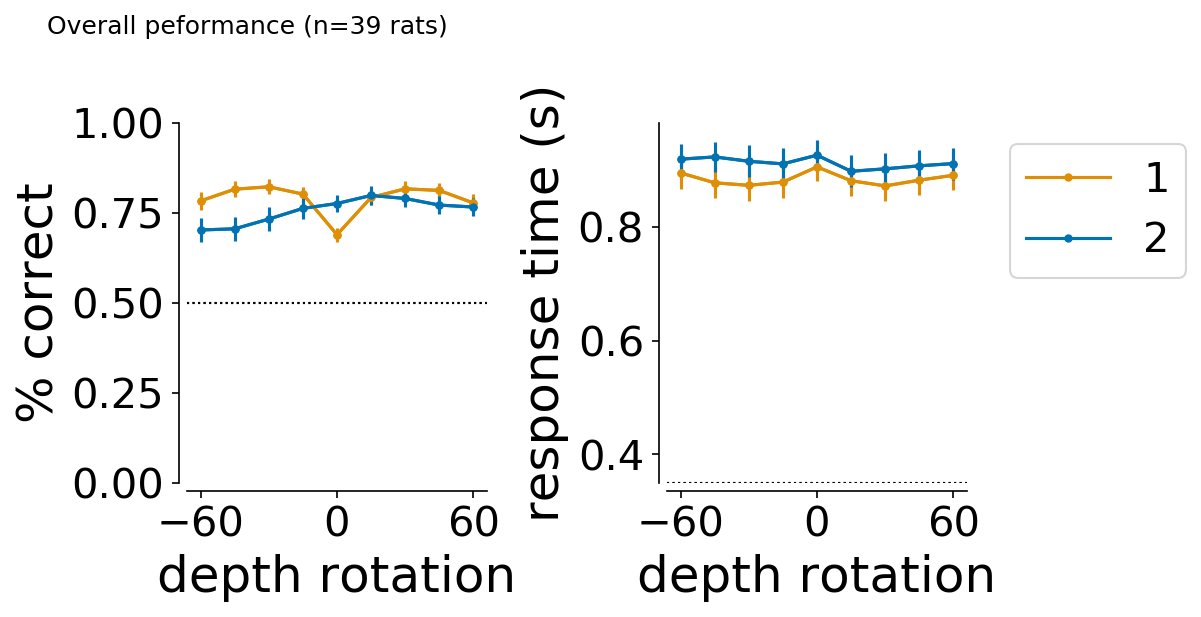

In [1273]:
fig = plot_accuracy_and_rt_split_objects(metric, feature_vs, mean_pcs, mean_rts, object_colors=object_colors)
fig.suptitle('Overall peformance (n=%i rats)' % len(animal_ids), x=0.2)

figname = 'accuracy-and-RT_%s_split-objectid_phase-%i_avg-%s' % (metric, curr_phase, '-'.join(cohort_list))
print(figname)
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [1276]:
def plot_accuracy_and_rt_split_objects_twinx(metric, feature_vs, mean_pcs, mean_rts):
    
    fig, axes = pl.subplots(1,2, sharex=True, sharey=False, dpi=dpi, figsize=(8,4))

    axis_colors = {0: 'tab:blue', 1: 'tab:red'}
    xlabel = metric.replace('_', ' ')

    for ax, objectid in zip(axes.flat, object_ids):

        mvals = mean_pcs[objectid].mean(axis=0)
        svals = spstats.sem(mean_pcs[objectid], axis=0)

        ax.plot(feature_vs, mean_pcs[objectid].mean(axis=0), marker='.', color=axis_colors[0])
        ax.errorbar(feature_vs, mvals, yerr=svals, marker='.', color=axis_colors[0])
        ax.tick_params(axis='y', labelcolor=axis_colors[0])
        ax.set_ylim([0, 1])

        rvals = mean_rts[objectid].mean(axis=0)
        svals = spstats.sem(mean_rts[objectid], axis=0)

        ax2 = ax.twinx()
        ax2.plot(feature_vs, rvals, marker='.', color=axis_colors[1])
        ax2.errorbar(feature_vs, rvals, yerr=svals, marker='.', color=axis_colors[1])
        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim([0.5, 1.2])


        if len(feature_vs) > 5:
            ax.set_xticks([int(f) for f in feature_vs if f%60==0]) #feature_vs[0::5])
        else:
            ax.set_xticks(feature_vs)
        ax.set_xlabel(xlabel)
        ax.set_title('Object %i' % objectid)

    axes[0].set_ylabel('Accuracy', color=axis_colors[0])
    ax2.set_ylabel('Response time (s)', color=axis_colors[1])

    sns.despine(trim=False, offset=4, right=False)
    pl.subplots_adjust(bottom=0.2, left=0.15, wspace=1.0, right=0.85, top=0.8)
    
    return fig


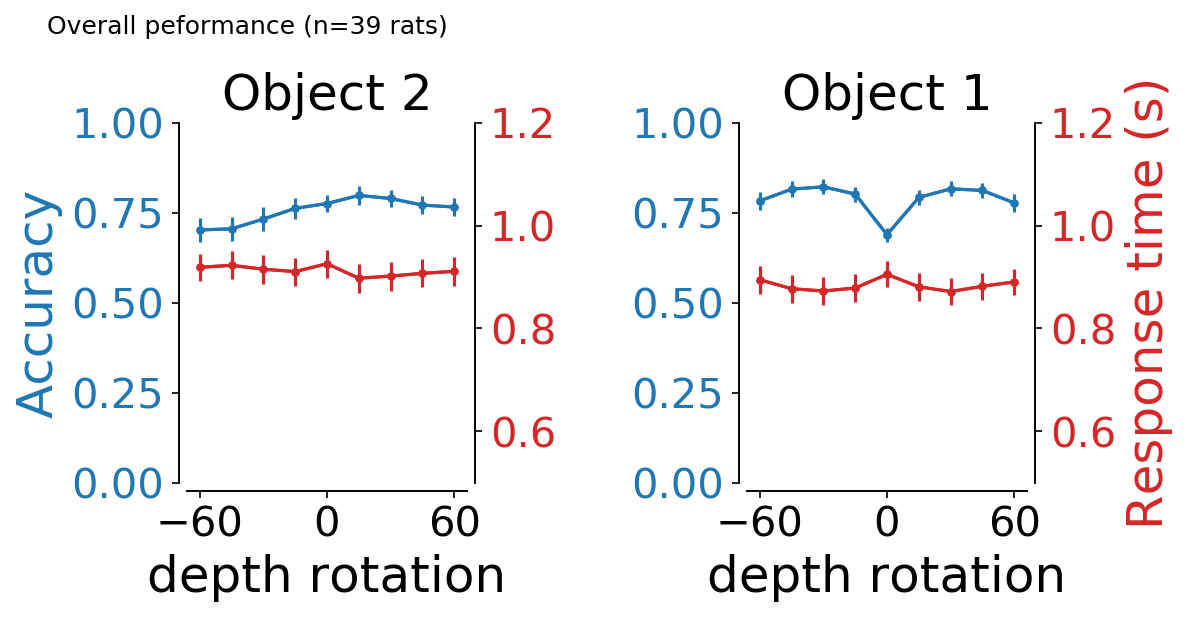

In [1277]:

fig = plot_accuracy_and_rt_split_objects_twinx(metric, feature_vs, mean_pcs, mean_rts)
fig.suptitle('Overall peformance (n=%i rats)' % len(animal_ids), x=0.2)

figname = 'twinx_accuracy-and-RT_%s_split-objectid_phase-%i_avg-%s' % (metric, curr_phase, '-'.join(cohort_list))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [1278]:
def plot_metric_by_animal(animal_ids, mean_pcs, nr=4, nc=8, metric_name='accuracy',
                          object_colors=None, cmap='colorblind'):

    object_ids = mean_pcs.keys()
    
    if object_colors is None:
        color_list = sns.color_palette(cmap, n_colors=len(object_ids))
        object_colors = dict((k, col) for k, col in zip(object_ids, color_list))
        
        
    fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True, dpi=dpi, figsize=(nc, nr))

    for ai, animalid in enumerate(animal_ids):
        ax = axes.flat[ai]
        for objectid in object_ids:

            mean_vals = mean_pcs[objectid][ai]

            sem_vals = spstats.sem(mean_pcs[objectid], axis=0)
            ax.plot(feature_vs, mean_pcs[objectid][ai], color=object_colors[objectid])
            ax.plot(feature_vs, mean_pcs[objectid][ai], color=object_colors[objectid])

            if metric_name == 'accuracy':
                yticks = [0.0, 0.5, 1.]
                ax.set_ylim([0, 1.])
                ax.set_yticks(yticks)
            else:
                yticks = ax.get_yticks()
                
            ax.set_yticklabels(yticks, fontsize=8)

            
            if len(feature_vs) > 5:
                xticks = [int(f) for f in feature_vs if f%60==0]
            else:
                xticks = feature_vs
            
            ax.set_xticks(xticks) #feature_vs[0::5])            
            ax.set_xticklabels(xticks, fontsize=8)
            
        ax.set_title(animalid, loc='left', fontsize=6, pad=5)

    for ii in np.arange(ai+1, nr*nc):
        axes.flat[ii].axis('off')
    # axes[0].set_title('Accuracy')
    # axes[1].set_title('Response time')
    #axes.flat[-1].legend(bbox_to_anchor=(1.5, 1))

    # axes[0].set_ylim([0.5, 1])
    # axes[1].set_ylim([0.8, 1])

    # sns.despine(trim=True, offset=4)
    pl.subplots_adjust(bottom=0.3, left=0.2, wspace=0.5, hspace=0.5)

    return fig

In [1279]:

nr = int(np.ceil(len(animal_ids) / 8.))
nc = min([ int(round(len(animal_ids)/float(nr))) , 8.])
print(nr, nc)

(5, 8)


depth_rotation_accuracy-by-animal_phase-5_AK-AL-AM
/n/coxfs01/behavior-data/threeport/processed/KLM/phase-5/performance


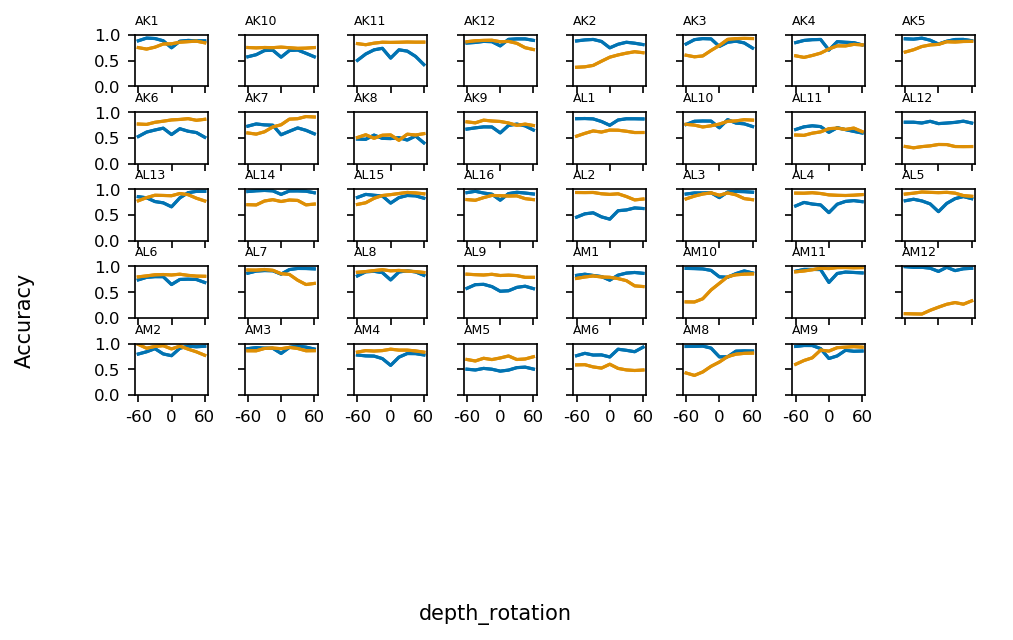

In [1280]:
fig = plot_metric_by_animal(animal_ids, mean_pcs, nr=nr, nc=nc, metric_name='accuracy')
fig.text(0.5, 0.1, metric, ha='center')
fig.text(0.1, 0.5, 'Accuracy', va='center', rotation='vertical')
pl.subplots_adjust(bottom=0.4, left=0.2, wspace=0.5, hspace=0.5)

figname = '%s_accuracy-by-animal_phase-%i_%s' % (metric, curr_phase, '-'.join(cohort_list))
print(figname)
pl.savefig(os.path.join(performance_dir, '%s.png' % figname))
print(performance_dir)

depth_rotation_RT-by-animal_phase-5_AK-AL-AM
/n/coxfs01/behavior-data/threeport/processed/KLM/phase-5/reaction-time


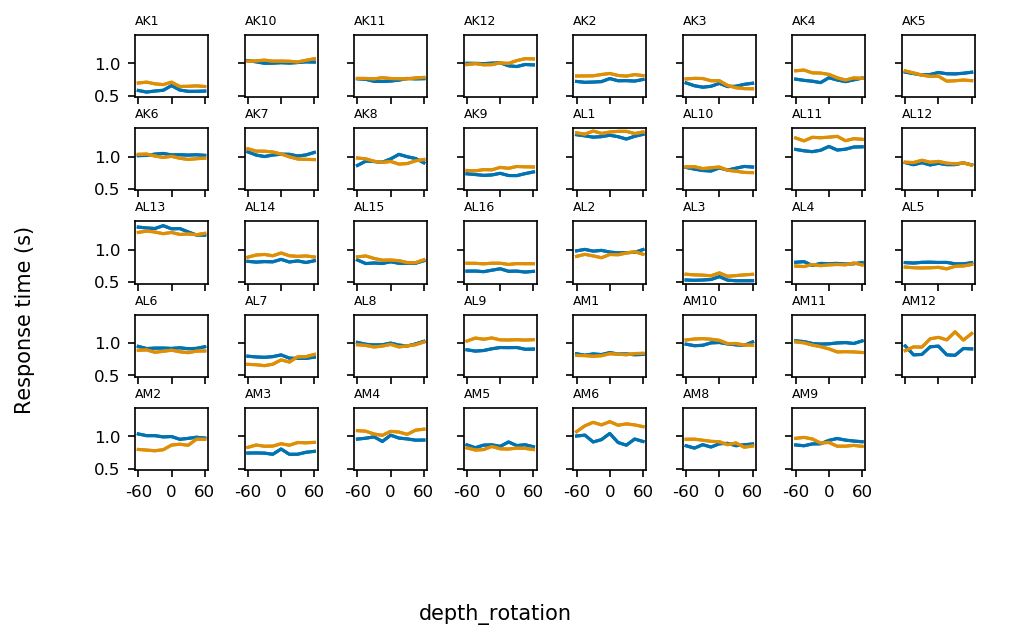

In [1281]:
fig = plot_metric_by_animal(animal_ids, mean_rts, nr=nr, nc=nc, metric_name='rt')
fig.text(0.5, 0.1, metric, ha='center')
fig.text(0.1, 0.5, 'Response time (s)', va='center', rotation='vertical')
pl.subplots_adjust(bottom=0.3, left=0.2, wspace=0.5, hspace=0.5)

figname = '%s_RT-by-animal_phase-%i_%s' % (metric, curr_phase, '-'.join(cohort_list))
print(figname)
pl.savefig(os.path.join(rt_dir, '%s.png' % figname))
print(rt_dir)

# Response time

In [1282]:
def plot_RT_by_transform_split_objects(metric, mean_rts, is_relative=True):
    animal_ids = sorted(mean_rts.index.levels[0].values, key=util.natural_keys)
    object_ids = mean_rts.index.levels[1].values

    fig, axes = pl.subplots(1,2, sharex=True, sharey=True, dpi=dpi, figsize=(8,4))

    relative_ = True
    xlabel = metric.replace('_', ' ')
    for animalid in animal_ids:
        for ax, oi in zip(axes, object_ids):
            feature_vs = mean_rts[animalid].index.levels[1].values
            ax.plot(feature_vs, mean_rts[animalid][str(oi)], 'k', alpha=0.5, lw=0.5)

    mean_by_object = mean_rts.groupby(['object', metric]).mean()
    sem_by_object = mean_rts.groupby(['object', metric]).apply(spstats.sem)

    for ax, oi in zip(axes, object_ids):
        nv = len(mean_by_object[str(oi)])
        ax.plot(feature_vs, mean_by_object[str(oi)], lw=3, color='k')
        ax.errorbar(feature_vs, mean_by_object[str(oi)], yerr=sem_by_object[str(oi)], color='k')
        ax.set_title('Object %s' % oi, loc='left')

        if len(feature_vs) > 5:
            xticks = [int(f) for f in feature_vs if f%60==0]
        else:
            xticks = feature_vs
        ax.set_xticks(xticks)
            
    sns.despine(trim=False, offset=4)
    pl.subplots_adjust(bottom=0.2, left=0.2, top=0.8)

    fig.text(0.5, 0.03, xlabel, ha='center', fontsize=24)
    rel_str = 'relative ' if is_relative else ''
    fig.text(0.04, 0.5, '%sRT' % rel_str, va='center', rotation='vertical', fontsize=24)
    return fig


#### Only look at success

In [1283]:
successdf = df[(df['outcome']=='success')]

successdf['abs_%s' % col_feature] = np.abs(successdf[col_feature])
successdf['abs_%s' % row_feature] = np.abs(successdf[row_feature])


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1284]:
get_relative = True

metric = 'abs_depth_rotation'
training_value = 0. if 'rotation' in metric else 30.

filter_feature = 'size'
filter_value = 30.

#### Get mean <METRIC> (across trials for each session) of each condition type on success trials
grouped_rts = successdf.groupby(['object', filter_feature, metric, 'animalid', 'sessionid']).mean()

In [1285]:
g

animalid cohort  depth_rotation  duration light_position  \
1389607      AM9     AM               0   5031676           None   
1389608      AM9     AM              15   5848077           None   
1389609      AM9     AM               0   5214951           None   
1389610      AM9     AM             -60    883043           None   
1389611      AM9     AM              30   5681466           None   
1389612      AM9     AM               0   5348241           None   
1389613      AM9     AM             -15   5364902           None   
1389614      AM9     AM               0   5281596           None   
1389615      AM9     AM               0   5714787           None   
1389616      AM9     AM               0   5314920           None   
1389617      AM9     AM              60   5131646           None   
1389618      AM9     AM              15   5331579           None   
1389619      AM9     AM             -45    816398           None   
1389620      AM9     AM               0   5098321           None   
1389621      AM9     AM             -60   5181630           None   
1389622      AM9     AM             -45   5664804           None   
1389623      AM9     AM               0   5414884           None   
1389624      AM9     AM              30   5131645           None   
1389625      AM9     AM              45   5181628           None   
1389626      AM9     AM              60   5248273           None   
1389627      AM9     AM             -15   5148307           None   
1389628      AM9     AM               0   5431547           None   
1389629      AM9     AM             -30   1399539           None   
1389630      AM9     AM             -30   5181628           None   
1389631      AM9     AM              45   5448209           None   
1389632      AM9     AM               0   5264934           None   
1389633      AM9     AM               0   5598159           None   
1389634      AM9     AM               0   5231615           None   
1389635      AM9     AM               0   5898060           None   
1389636      AM9     AM               0   5065000           None   
...          ...    ...             ...       ...            ...   
1390144      AM9     AM             -30   5181629           None   
1390145      AM9     AM               0   5498190           None   
1390146      AM9     AM             -60   6281269           None   
1390147      AM9     AM               0   5198289           None   
1390148      AM9     AM               0   5298258           None   
1390149      AM9     AM              45   5781431           None   
1390150      AM9     AM              30   6597832           None   
1390151      AM9     AM             -30   5881398           None   
1390152      AM9     AM               0   5364901           None   
1390153      AM9     AM               0   5314918           None   
1390154      AM9     AM               0   5298258           None   
1390155      AM9     AM              45   5181629           None   
1390156      AM9     AM               0   5281596           None   
1390157      AM9     AM             -15   5114984           None   
1390158      AM9     AM               0   5314921           None   
1390159      AM9     AM              30   5414887           None   
1390160      AM9     AM             -45   5398224           None   
1390161      AM9     AM               0   5364904           None   
1390162      AM9     AM              15   5798093           None   
1390163      AM9     AM              60   5231612           None   
1390164      AM9     AM              60   5548175           None   
1390165      AM9     AM             -45   5214952           None   
1390166      AM9     AM             -30   5264935           None   
1390167      AM9     AM              45   5298257           None   
1390168      AM9     AM              30   5131646           None   
1390169      AM9     AM               0   5348241           None   
1390170      AM9     AM               0   5781432           None

In [1287]:
#### Get mean <METRIC> (across session means) for each animal
grouped_rts_mean = grouped_rts['response_time'].groupby(['object', filter_feature, metric, 'animalid']).mean()

#### Normalize RT to training view
if get_relative:
    for ai, g in grouped_rts_mean.groupby(['animalid', 'object']):
#         ref_val = float(g.loc[slice(oi), filter_value, training_value]) #float(g.loc[slice(None), slice(None), 0, 0].values)
#         ref_val = float(g.loc[slice(oi), slice(str(filter_value)), training_value]) #float(g.loc[slice(None), slice(None), 0, 0].values)
        ref_val = float(g.loc[slice(str(oi)), filter_value, training_value]) #float(g.loc[slice(None), slice(None), 0, 0].values)

        grouped_rts_mean.loc[g.index] = g.divide(ref_val)
        
#### For each condition, get mean across rats
rt_per_animal = grouped_rts_mean.groupby(['object', filter_feature, metric]).mean()
rt_per_animal_sem = grouped_rts_mean.groupby(['object', filter_feature, metric]).apply(spstats.sem)


In [1288]:
rt_per_animal

object  size  abs_depth_rotation
1       15.0  0                     1.236406
        20.0  0                     1.143233
        25.0  0                     1.057400
        30.0  0                     1.000000
              15                    1.003667
              30                    0.996660
              45                    1.007990
              60                    1.021078
        35.0  0                     0.965688
        40.0  0                     0.941758
2       15.0  0                     1.061042
        20.0  0                     1.031253
        25.0  0                     1.015424
        30.0  0                     1.000000
              15                    0.999665
              30                    1.008727
              45                    1.017305
              60                    1.017671
        35.0  0                     1.003067
        40.0  0                     1.001922
Name: response_time, dtype: float64

#### plot for 1 transform value

In [1289]:

filter_value = 30.

curr_grp = grouped_rts_mean.loc[(grouped_rts_mean.index.get_level_values(filter_feature)==filter_value)].copy()

curr_grp_means = curr_grp.groupby(['animalid', 'object', metric]).mean()
curr_grp_sems = curr_grp.groupby(['animalid', 'object', metric]).apply(spstats.sem)


rel-RT_abs_depth_rotation_split-objects_filter-size-30_phase-5
/n/coxfs01/behavior-data/threeport/processed/KLM/phase-5/reaction-time


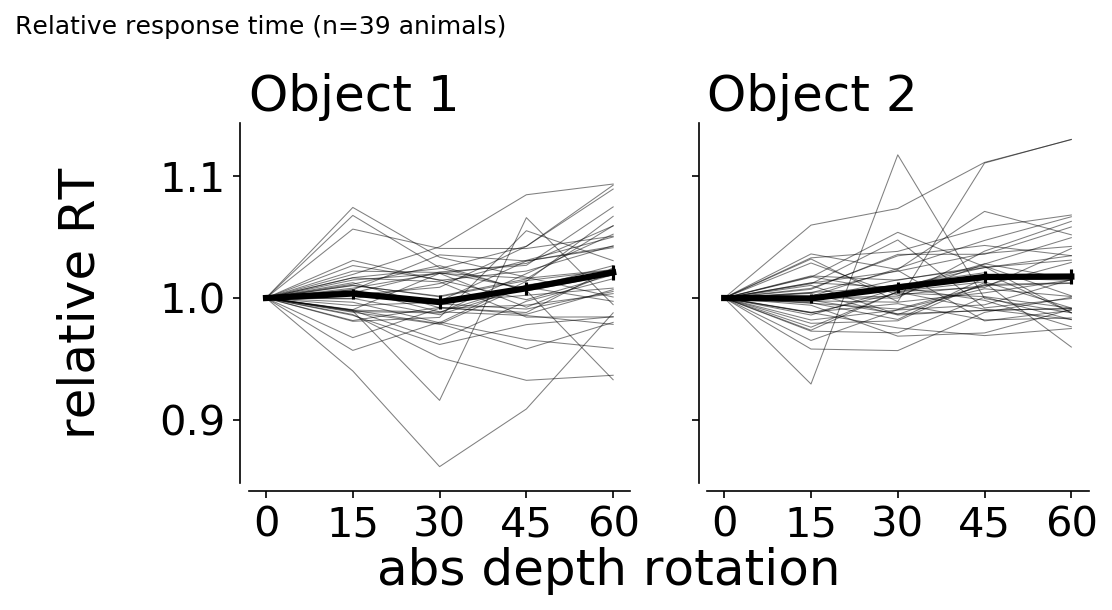

In [1290]:
fig = plot_RT_by_transform_split_objects(metric, curr_grp_means, is_relative=get_relative)
fig.suptitle('Relative response time (n=%i animals)' % len(animal_ids), x=0.21)

figname = 'rel-RT_%s_split-objects_filter-%s-%i_phase-%i' % (metric, filter_feature, filter_value, curr_phase)

pl.savefig(os.path.join(rt_dir, '%s.png' % figname))
print(figname)
print(rt_dir)


#### stats

In [1291]:
arr_ = dict((k, []) for k in object_ids)

for (oid, drot), g in curr_grp_means.groupby(['object', metric]):
    arr_[int(oid)].append(g.values)


In [1292]:
for oi, vs in arr_.items():
    
    print(spstats.f_oneway(*arr_[oi]))
    print(spstats.kruskal(*arr_[oi]))

    stat, p = spstats.friedmanchisquare(*arr_[oi])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')


F_onewayResult(statistic=3.98380628447217, pvalue=0.003971221037547553)
KruskalResult(statistic=15.468320877806137, pvalue=0.0038222401003075355)
Statistics=27.241, p=0.000
Different distributions (reject H0)
F_onewayResult(statistic=3.8326304096555104, pvalue=0.005088802148492798)
KruskalResult(statistic=9.858571640720315, pvalue=0.04287861553868294)
Statistics=16.185, p=0.003
Different distributions (reject H0)


#### Plot RT for each filtered value

In [1293]:
transform_values = sorted(rt_per_animal.index.levels[1].values)
hue_feature = filter_feature

col_list1 = sns.color_palette('Purples', n_colors=len(transform_values))
col_list2 = sns.color_palette('Greens', n_colors=len(transform_values))
diverging_ = sns.diverging_palette(220, 20, n=len(transform_values))

h_colors1 = dict((k, c) for k, c in zip(transform_values, col_list1))
#h_colors2 = dict((k, c) for k, c in zip(hue_values, col_list2))
#feature_colors = {'1': h_colors1, '2': h_colors2}

rel-RT_abs_depth_rotation_split-objects_hue-size_phase-5


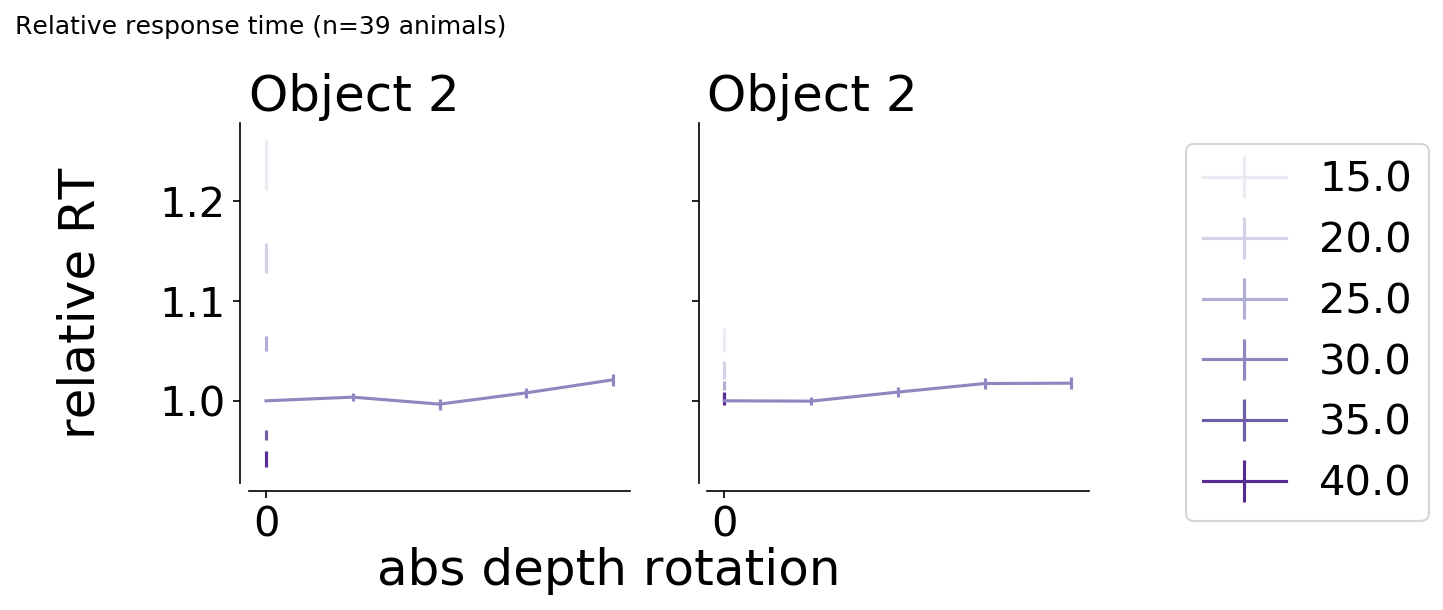

In [1294]:
fig, axes = pl.subplots(1,2, sharex=True, sharey=True, dpi=dpi, figsize=(8,4))

xlabel = metric.replace('_', ' ')

for (objectid, fv), g in rt_per_animal.groupby(['object', filter_feature]):
    ax = axes[0] if objectid=='1' else axes[1]
    
    feature_vs = g.index.get_level_values(level=-1).values
    
    sem_vs = rt_per_animal_sem.loc[g.index][(objectid, fv)].values
    ax.errorbar(feature_vs, g.values, yerr=sem_vs, color=h_colors1[fv], label=fv)

    if len(feature_vs) > 5:
        xticks = [int(f) for f in feature_vs if f%60==0]
    else:
        xticks = feature_vs
    ax.set_xticks(xticks)

    ax.set_title('Object %s' % oi, loc='left')
    
ax.legend(bbox_to_anchor=(1.2,  1))

sns.despine(trim=False, offset=4)
pl.subplots_adjust(bottom=0.2, left=0.2, top=0.8)

fig.text(0.5, 0.03, xlabel, ha='center', fontsize=24)
rel_str = 'relative ' if get_relative else ''
fig.text(0.04, 0.5, '%sRT' % rel_str, va='center', rotation='vertical', fontsize=24)
fig.suptitle('Relative response time (n=%i animals)' % len(animal_ids), x=0.21)


figname = 'rel-RT_%s_split-objects_hue-%s_phase-%i' % (metric, filter_feature, curr_phase)
print(figname)
pl.savefig(os.path.join(rt_dir, '%s.png' % figname))

#### Plot % correct as a function of depth rotation (split object ids)

/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-by-depth_rotation_split-objectid_size-30_phase5_AK


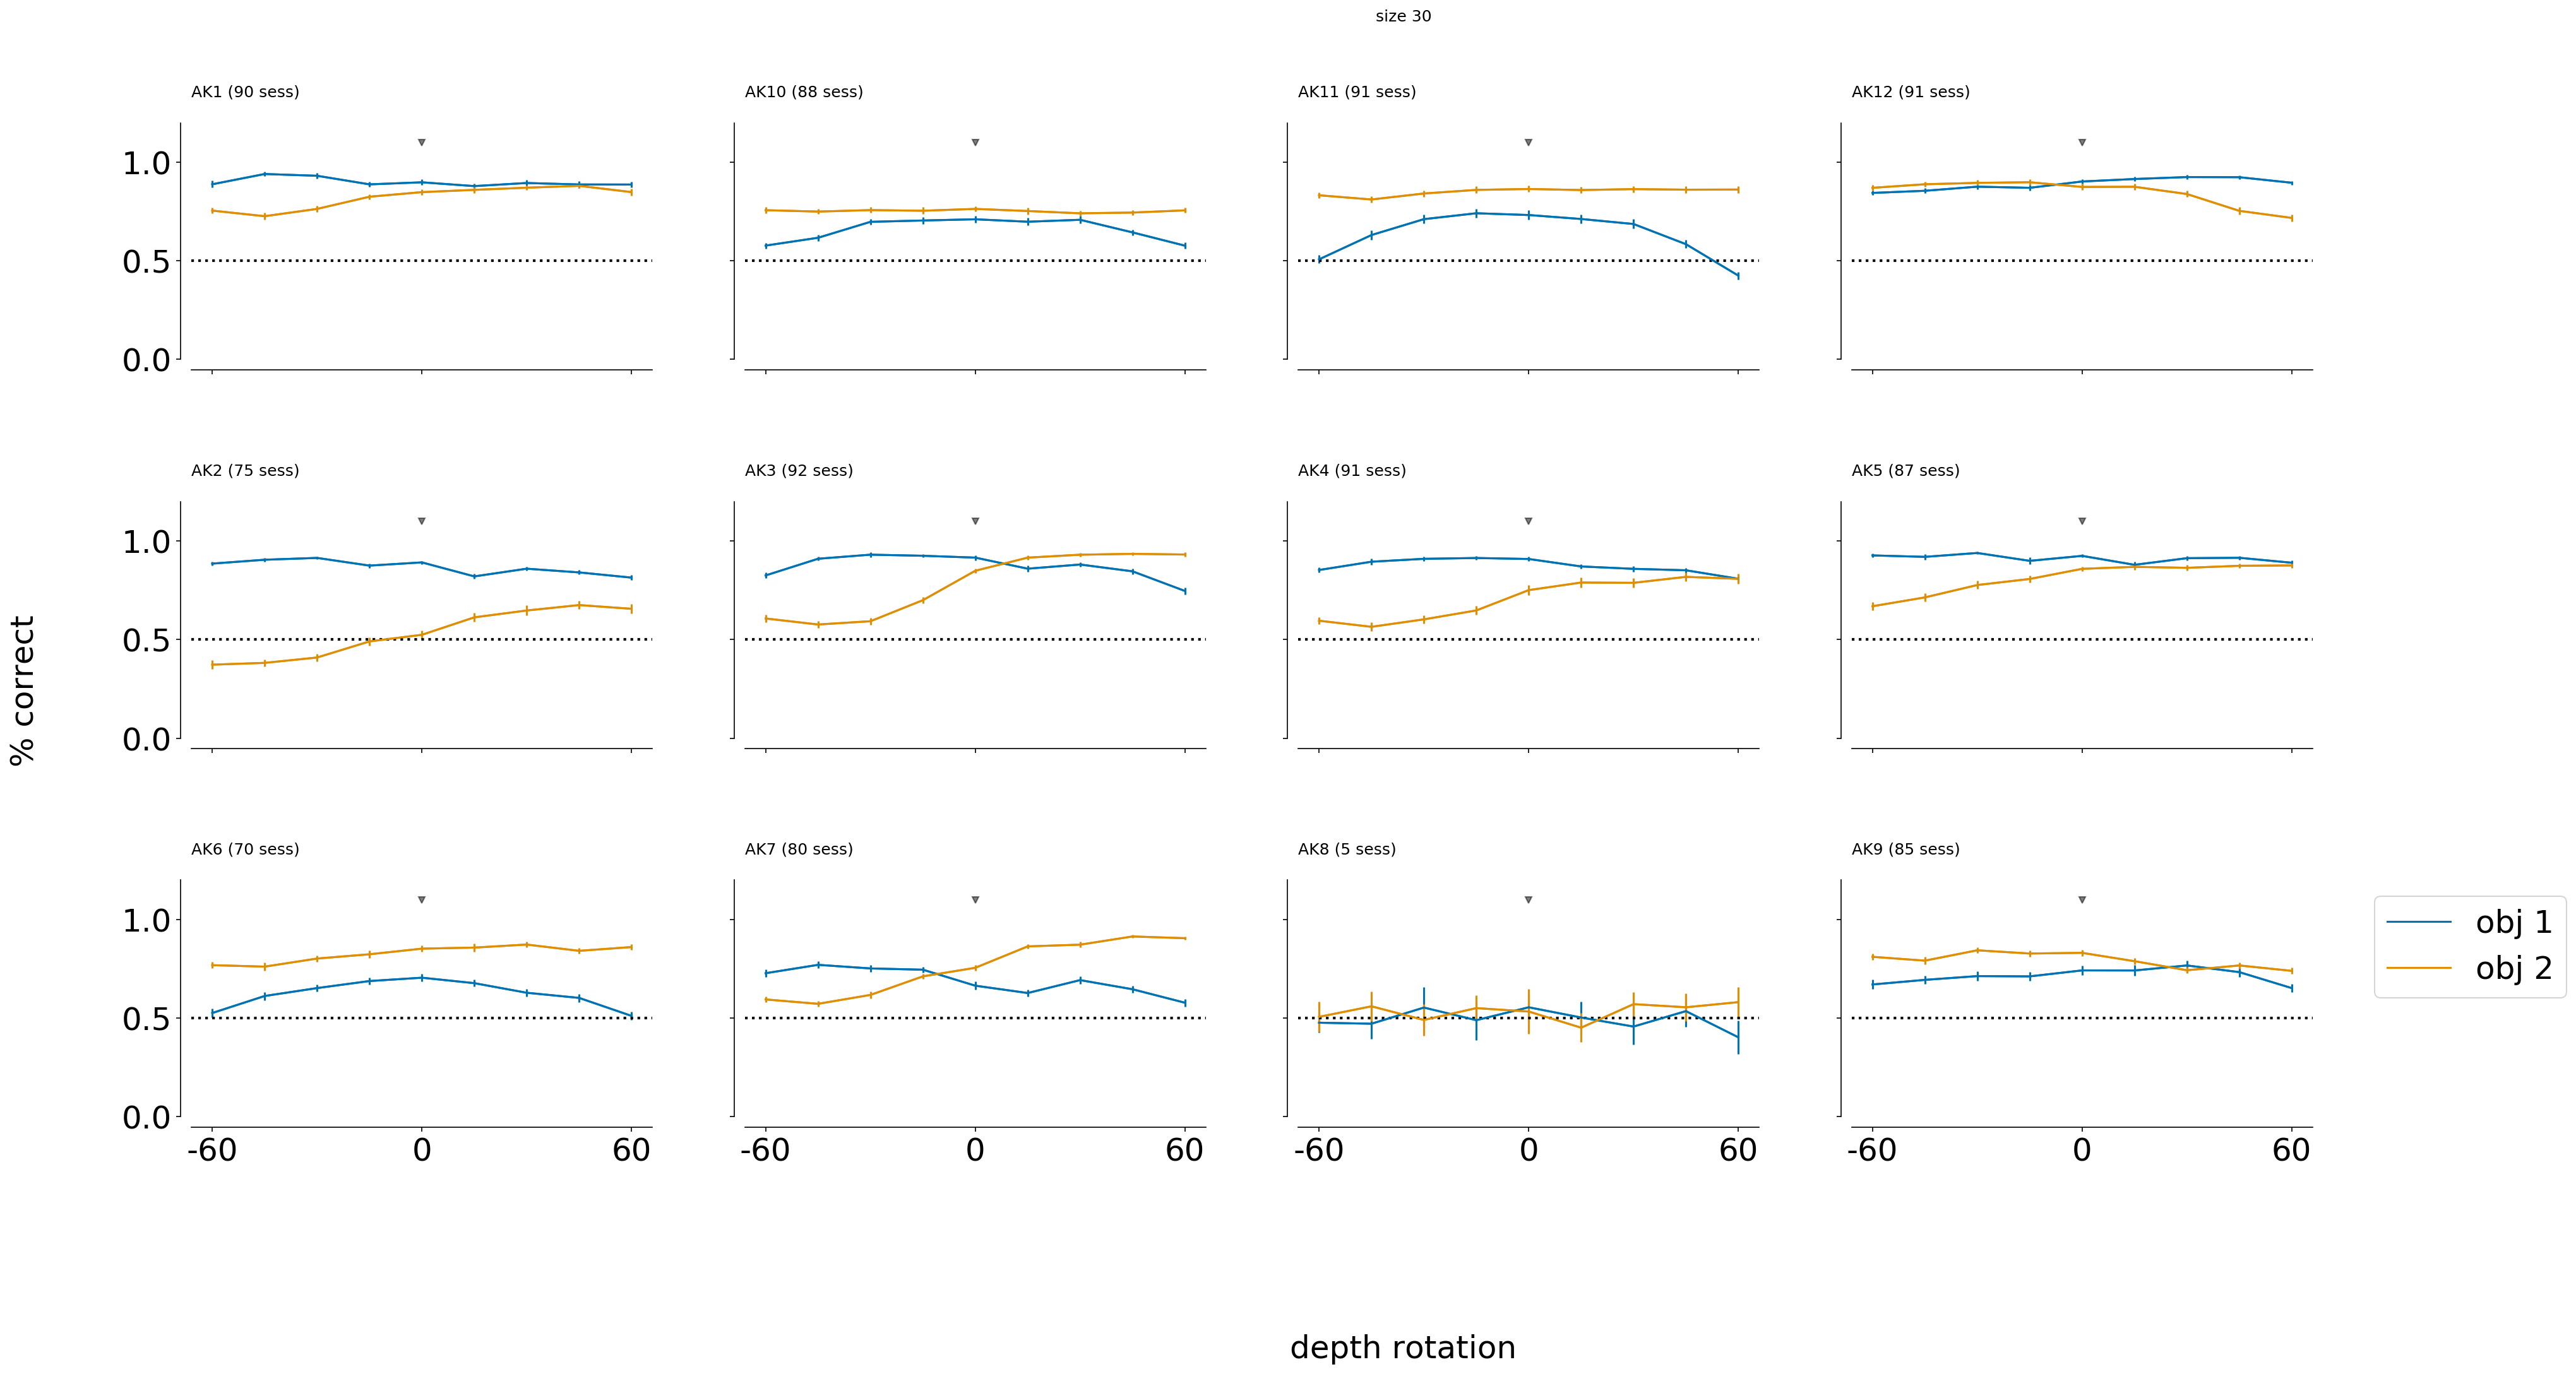

In [1082]:
nr=3
nc=4

curr_feature = 'depth_rotation'
curr_metric = 'perc_correct'

x_axis_values = expected_prots if curr_feature=='rotation' else expected_drots

filter_feature = 'size'
filter_value = 30.

datadf = perfdf[perfdf[filter_feature]==filter_value].copy()

fig, axes = pl.subplots(nr, nc, figsize=(nc*8, nr*5), sharex=True, sharey=True, dpi=dpi)

for ai, (animalid, agroup) in enumerate(datadf.groupby(['animalid'])):
    ax = axes.flat[ai]
    n_sessions = len(agroup['session'].unique())
    for objectid, ogroup in agroup.groupby(['objectid']):
        
        tested_values = [v for v, g in ogroup.groupby([curr_feature])]
        performance_values = [g[curr_metric].mean() for v, g in ogroup.groupby([curr_feature])]
        peformance_sem = [spstats.sem(g[curr_metric]) for v, g in ogroup.groupby([curr_feature])]
        
        ax.plot(tested_values, performance_values, color=object_colors[objectid], 
                label='obj %s' % (objectid), linestyle='-')
        ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                    color=object_colors[objectid], linestyle='-')
        ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=12, pad=20, loc='left')
    
    ax.axhline(y=0.5, linestyle=':', color='k', lw=2)
    ax.set_ylim([0, 1.2])    
    ax.set_yticks(np.linspace(0, 1, 3))
    
    ax.plot(0, 1.1, markersize=5, marker='v', color='k', alpha=0.5)
    
    xticks = [int(x) for x in x_axis_values if x%60==0 ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
ax.legend(bbox_to_anchor=(1.1,1.))

for i in np.arange(ai+1, nr*nc):
    ax=axes.flat[i]
    ax.axis('off')

pl.subplots_adjust(left=0.1, right=0.8, top=0.9, hspace=0.6, wspace=0.2, bottom=0.2)
sns.despine(trim=False, offset=8) #, right=False)

fig.suptitle('%s %i' % (filter_feature, filter_value), fontsize=12) #, pad=20)

fig.text(0.5, 0.03, 'depth rotation', ha='center')
fig.text(0.04, 0.5, '% correct', va='center', rotation='vertical')

figname = '%s-by-%s_split-objectid_%s-%i_phase%i_%s' % (curr_metric, curr_feature, filter_feature, filter_value, 
                                                            curr_phase, cohort)

pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
print(outdir)
print(figname)



## Plot RT as twin axis (plot separately for each object)

In [1086]:

curr_feature = 'depth_rotation' # 'rotation'
curr_metric = 'perc_correct'
                     
if curr_phase in [4,5]:
    filter_feature = 'size'
    filter_value = 30.
    x_axis_values = expected_drots
    training_value = 0
    
elif curr_phase == 6:
    filter_feature = 'depth_rotation'
    filter_value = 0.
    x_axis_values = expected_prots
    training_value = 0
    
datadf = perfdf[ (perfdf[filter_feature]==filter_value) ].copy()


# datadf = perfdf[ (perfdf[filter_feature]==filter_value)
#                & (perfdf[filter_feature2]==filter_value2) ].copy()


In [1088]:
curr_outdir = os.path.join(processed_dir, 'reaction-time')
print(curr_outdir)

/n/coxfs01/behavior-data/threeport/processed/reaction-time


/n/coxfs01/behavior-data/threeport/processed/reaction-time
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-30_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/reaction-time
perc_correct-twin-avg_rt-by-depth_rotation_object-2_size-30_phase5_AK


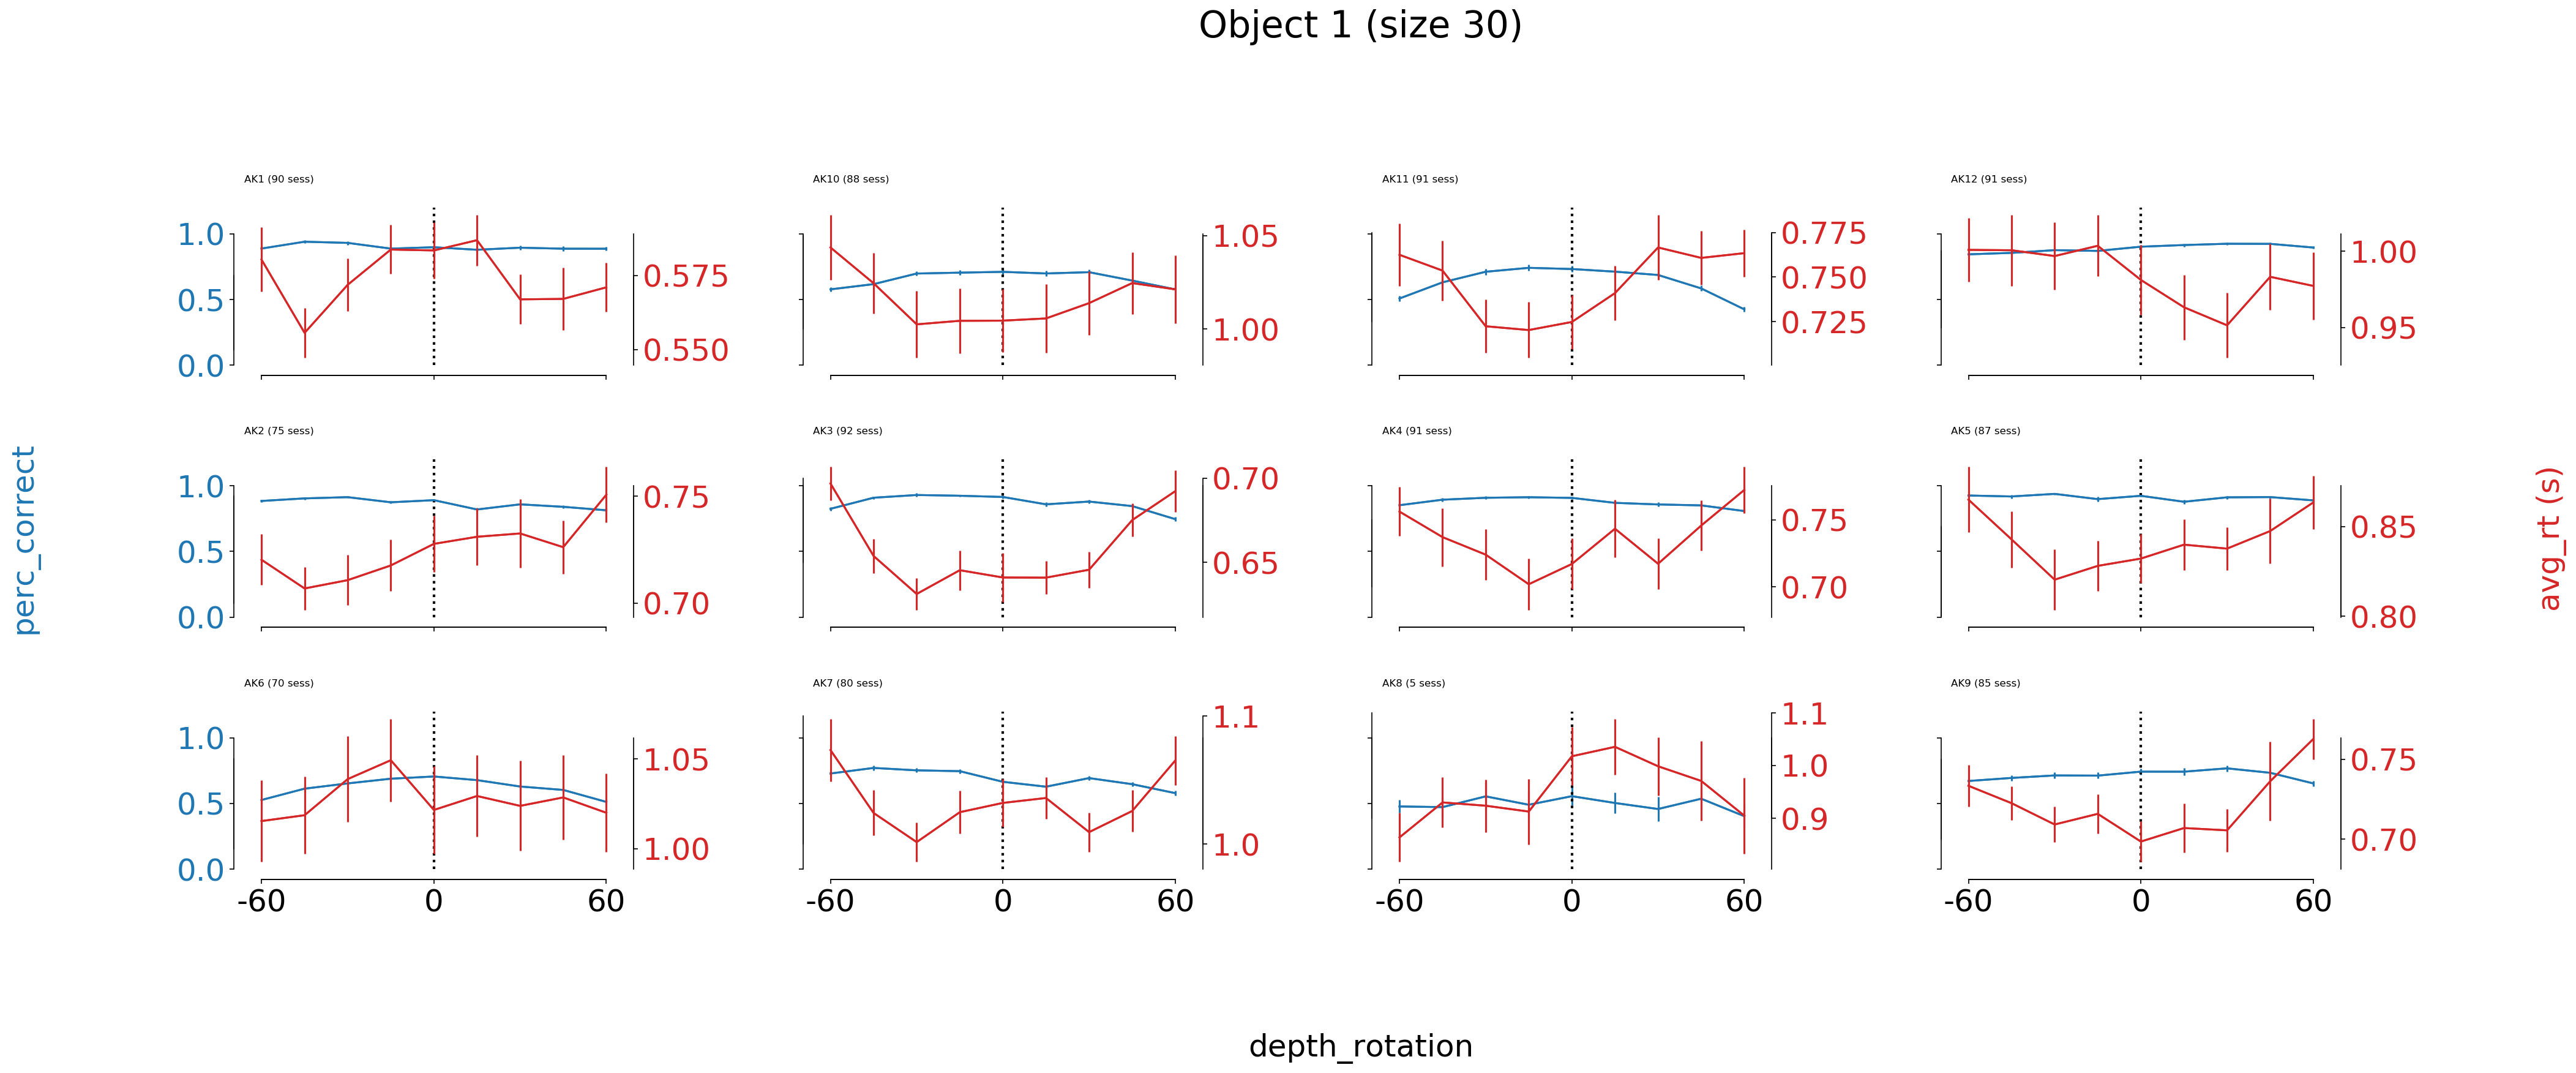

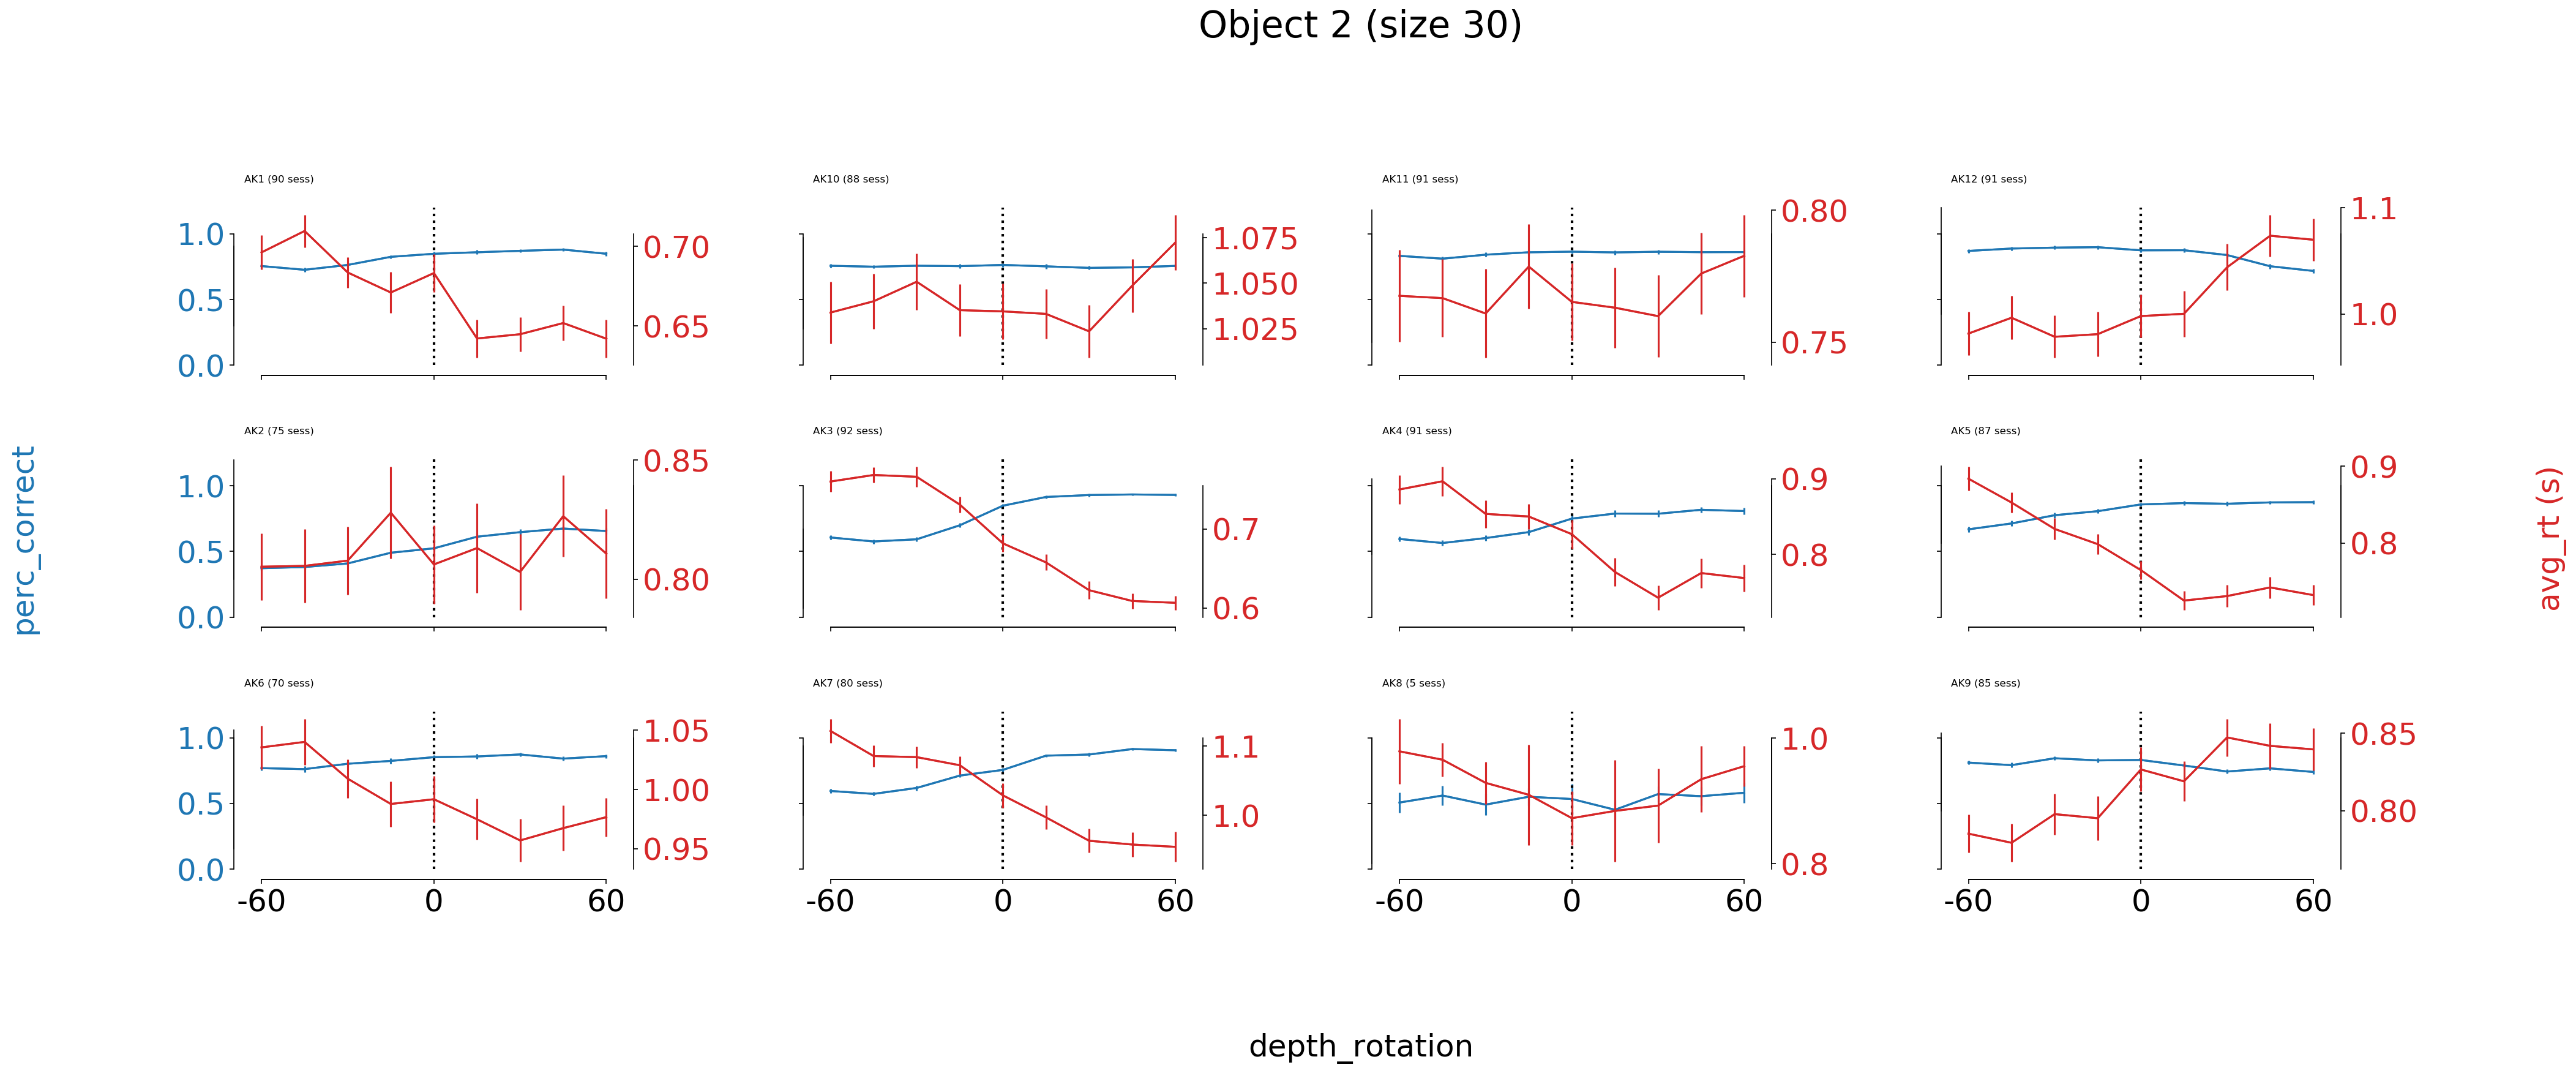

In [1089]:

datadf = perfdf[ (perfdf[filter_feature]==filter_value) ].copy()

twin_metric = 'avg_rt'
axis_colors = {0: 'tab:blue', 1: 'tab:red'}

objectid = '1'
for objectid in ['1', '2']:
    fig, axes = pl.subplots(nr, nc, dpi=dpi, figsize=(nc*8, nr*4), sharex=True, sharey=True)

    for ai, (animalid, agroup) in enumerate(datadf.groupby(['animalid'])):
        ax = axes.flat[ai]
        n_sessions = len(agroup['session'].unique())
        ogroup = agroup[agroup['objectid']==objectid]

        tested_values = [v for v, g in ogroup.groupby([curr_feature])]
        performance_values = [g[curr_metric].mean() for v, g in ogroup.groupby([curr_feature])]
        peformance_sem = [spstats.sem(g[curr_metric]) for v, g in ogroup.groupby([curr_feature])]

        ax.plot(tested_values, performance_values, color=axis_colors[0],
                label='obj %s' % (objectid), linestyle='-')
        ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                    color=axis_colors[0], linestyle='-')
        ax.tick_params(axis='y', labelcolor=axis_colors[0])

        ax2 = ax.twinx()
        rt_values = [g[twin_metric].mean() for v, g in ogroup.groupby([curr_feature])]
        rt_sem = [spstats.sem(g[twin_metric]) for v, g in ogroup.groupby([curr_feature])]

        ax2.plot(tested_values, rt_values, color=axis_colors[1], 
                label='obj %s' % (objectid), linestyle='-')
        ax2.errorbar(tested_values, rt_values, yerr=rt_sem, 
                    color=axis_colors[1], linestyle='-')

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])

        ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=8, pad=20, loc='left')
        #ax.axhline(y=0.5, linestyle=':', color='k', lw=2)
        ax.axvline(x=training_value, linestyle=':', color='k', lw=2)

        ax.set_ylim([0, 1.2])

        ax.set_yticks(np.linspace(0, 1, 3))
        xticks = [int(x) for x in x_axis_values if x%60==0 ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)

    #ax.legend(bbox_to_anchor=(1.4,1.))

    for i in np.arange(ai+1, nr*nc):
        ax=axes.flat[i]
        ax.axis('off')

    pl.subplots_adjust(left=0.12, right=0.83, top=0.8, hspace=0.6, wspace=0.5, bottom=0.2)
    sns.despine(trim=True, offset=8, right=False)


    fig.suptitle("Object %s (%s %i)" % (objectid, filter_feature, filter_value))

    fig.text(0.5, 0.03, curr_feature, ha='center', color='k')
    fig.text(0.04, 0.5, curr_metric, va='center', rotation='vertical', color=axis_colors[0])
    fig.text(0.9, 0.5, '%s (s)' % twin_metric, va='center', rotation='vertical', color=axis_colors[1])

    figname = '%s-twin-%s-by-%s_object-%s_%s-%i_phase%i_%s' % (curr_metric, twin_metric, curr_feature,
                                                         objectid, filter_feature, filter_value, curr_phase, cohort)

    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
    print(curr_outdir)
    print(figname)



#### Cycle thru all filter values

In [1090]:
print(filter_feature)
print(curr_feature)

size
depth_rotation


In [1091]:
print(curr_outdir)
split_str = 'rt_%s_split-%s' % (curr_feature, filter_feature)

if not os.path.exists(os.path.join(curr_outdir, split_str)):
    os.makedirs(os.path.join(curr_outdir, split_str))
    
print(os.path.join(curr_outdir, split_str))

/n/coxfs01/behavior-data/threeport/processed/reaction-time
/n/coxfs01/behavior-data/threeport/processed/reaction-time/rt_depth_rotation_split-size


In [1092]:
# nr=3
# nc=4

filter_values = sorted(perfdf[filter_feature].unique())

for filter_value in filter_values: #filter_value = 30.
        
    datadf = perfdf[ (perfdf[filter_feature]==filter_value) ].copy()

    twin_metric = 'avg_rt'

    objectid = '1'
    fig, axes = pl.subplots(nr, nc, dpi=dpi, figsize=(nc*8, nr*4), sharex=True, sharey=True)

    for ai, (animalid, agroup) in enumerate(datadf.groupby(['animalid'])):
        ax = axes.flat[ai]
        n_sessions = len(agroup['session'].unique())
        ogroup = agroup[agroup['objectid']==objectid]

        tested_values = [v for v, g in ogroup.groupby([curr_feature])]
        performance_values = [g[curr_metric].mean() for v, g in ogroup.groupby([curr_feature])]
        peformance_sem = [spstats.sem(g[curr_metric]) for v, g in ogroup.groupby([curr_feature])]

        ax.plot(tested_values, performance_values, color=axis_colors[0],
                label='obj %s' % (objectid), linestyle='-')
        ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                    color=axis_colors[0], linestyle='-')
        ax.tick_params(axis='y', labelcolor=axis_colors[0])

        ax2 = ax.twinx()
        rt_values = [g[twin_metric].mean() for v, g in ogroup.groupby([curr_feature])]
        rt_sem = [spstats.sem(g[twin_metric]) for v, g in ogroup.groupby([curr_feature])]

        ax2.plot(tested_values, rt_values, color=axis_colors[1], 
                label='obj %s' % (objectid), linestyle='-')
        ax2.errorbar(tested_values, rt_values, yerr=rt_sem, 
                    color=axis_colors[1], linestyle='-')

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])

        ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=8, pad=20, loc='left')
        #ax.axhline(y=0.5, linestyle=':', color='k', lw=2)
        ax.axvline(x=training_value, linestyle=':', color='k', lw=2)

        ax.set_ylim([0, 1.2])

        ax.set_yticks(np.linspace(0, 1, 3))
        xticks = [int(x) for x in x_axis_values if x%60==0 ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)

    #ax.legend(bbox_to_anchor=(1.4,1.))

    for i in np.arange(ai+1, nr*nc):
        ax=axes.flat[i]
        ax.axis('off')

    pl.subplots_adjust(left=0.12, right=0.83, top=0.8, hspace=0.6, wspace=0.5, bottom=0.2)
    sns.despine(trim=True, offset=8, right=False)


    fig.suptitle("Object %s (%s %i)" % (objectid, filter_feature, filter_value))

    fig.text(0.5, 0.03, curr_feature, ha='center', color='k')
    fig.text(0.04, 0.5, curr_metric, va='center', rotation='vertical', color=axis_colors[0])
    fig.text(0.9, 0.5, '%s (s)' % twin_metric, va='center', rotation='vertical', color=axis_colors[1])

    figname = '%s-twin-%s-by-%s_object-%s_%s-%i_phase%i_%s' % (curr_metric, twin_metric, curr_feature,
                                                         objectid, filter_feature, filter_value, curr_phase, cohort)

    pl.savefig(os.path.join(curr_outdir, split_str, '%s.png' % figname))
    print(outdir)
    print(figname)
    pl.close()


/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-15_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-20_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-25_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-30_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-35_phase5_AK
/n/coxfs01/behavior-data/threeport/processed/performance
perc_correct-twin-avg_rt-by-depth_rotation_object-1_size-40_phase5_AK


#### Plot accuracy, split by size

In [1094]:
curr_outdir

'/n/coxfs01/behavior-data/threeport/processed/reaction-time'

In [1093]:
if curr_phase in [4, 5]:
    hue_values = expected_sizes
    hue_feature='size'
    col_list1 = sns.color_palette('Purples', n_colors=len(hue_values))
    col_list2 = sns.color_palette('Greens', n_colors=len(hue_values))

elif curr_phase == 6:
    hue_values = expected_drots
    hue_feature = 'depth_rotation'
    hue_cmap1 = 'hsv'
    sns.palplot(sns.diverging_palette(220, 20, n=7))
    col_list1 = sns.color_palette(sns.diverging_palette(220, 20, n=len(hue_values)))
    col_list2 = col_list1 #sns.color_palette(sns.diverging_palette(145, 280, s=85, l=25, n=len(hue_values)))
    

print(curr_feature)
    

h_colors1 = dict((k, c) for k, c in zip(hue_values, col_list1))
h_colors2 = dict((k, c) for k, c in zip(hue_values, col_list2))
feature_colors = {'1': h_colors1, '2': h_colors2}

depth_rotation


Text(0.04,0.5,'% correct')

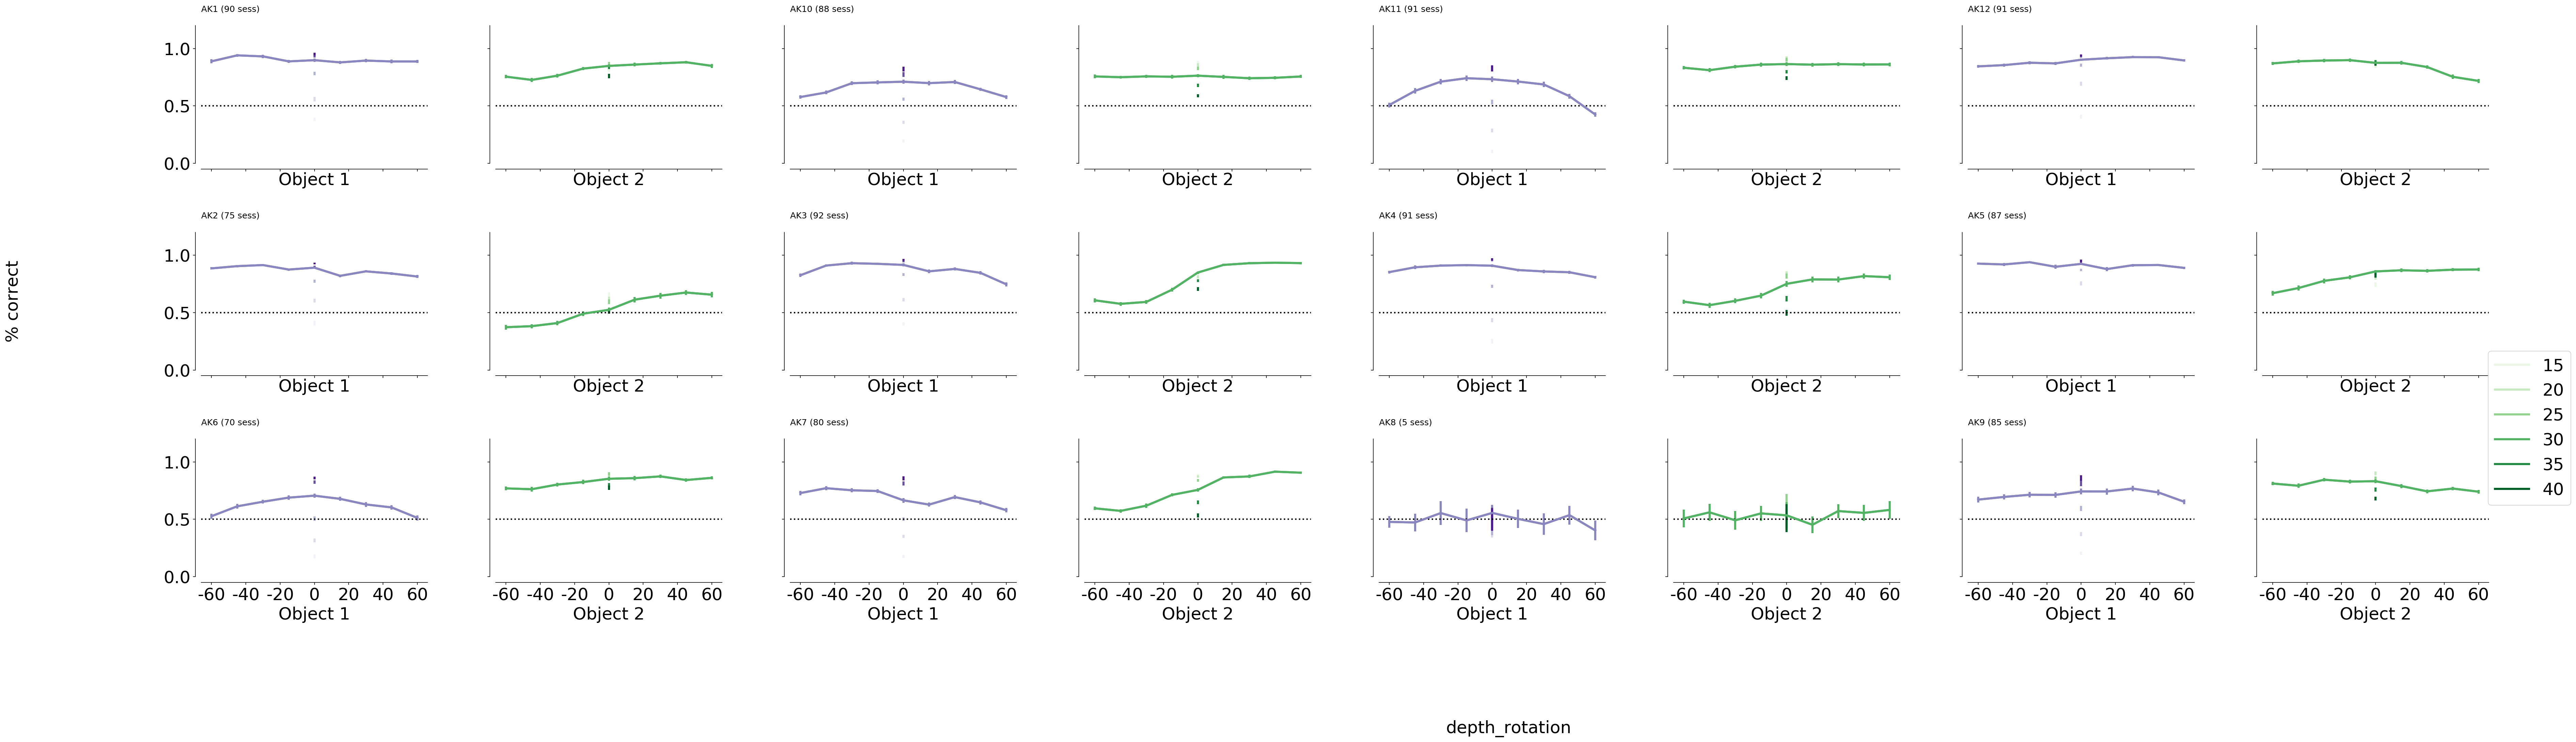

In [1096]:
nr=3
nc=4

fig, axes = pl.subplots(nr, nc*2, figsize=(nc*8*2, nr*6), sharex=True, sharey=True, dpi=dpi)
lw=3

ii = 0
for ai, (animalid, agroup) in enumerate(perfdf.groupby(['animalid'])):
    n_sessions = len(agroup['session'].unique())
    ii = ai*2
    for oi, (objectid, ogroup) in enumerate(agroup.groupby(['objectid'])):
        ax = axes.flat[ii+oi]        
        ogroup = agroup[agroup['objectid']==objectid]

        for hue_v, hgroup in ogroup.groupby([hue_feature]):
            
            tested_values = [v for v, g in hgroup.groupby([curr_feature])]
            performance_values = [g['perc_correct'].mean() for v, g in hgroup.groupby([curr_feature])]
            peformance_sem = [spstats.sem(g['perc_correct']) for v, g in hgroup.groupby([curr_feature])]

            curr_color = feature_colors[objectid][hue_v]
            ax.plot(tested_values, performance_values, color=curr_color, 
                    label='%i' % (hue_v), linestyle='-', lw=lw)
            ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                        color=curr_color, linestyle='-', lw=lw)
        if oi==0:
            ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=12, pad=20, loc='left')
        ax.axhline(y=0.5, linestyle=':', color='k', lw=2)

        ax.set_ylim([0, 1.2])
        ax.set_xlabel('Object %s' % objectid)
        
        ax.set_yticks(np.linspace(0, 1, 3))
        xticks = [int(x) for x in x_axis_values if x%20==0 ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    
ax.legend(bbox_to_anchor=(1.4,1.7))

for i in np.arange(i, nr*nc):
    ax=axes.flat[i]
    ax.axis('off')

    
pl.subplots_adjust(left=0.1, right=0.8, top=0.8, hspace=0.5, wspace=0.3, bottom=0.2)

sns.despine(trim=False, offset=8) #, right=False)

fig.text(0.5, 0.03, curr_feature, ha='center')
fig.text(0.04, 0.5, '% correct', va='center', rotation='vertical')

# figname = 'accuracy_by-%s_hue-%s_split-object_phase%i_%s' % (curr_feature, hue_feature, curr_phase, cohort)

# pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
# print(curr_outdir)
# print(figname)



In [1023]:
curr_outdir

'/n/coxfs01/behavior-data/threeport/processed/performance/inplane_rotations'

In [1037]:
splits_to_plot = [hue_v for hue_v, hgroup in ogroup.groupby([hue_feature])][0::4]
splits_to_plot


[-60, 0, 60]

/n/coxfs01/behavior-data/threeport/processed/performance/inplane_rotations
accuracy_by-rotation_subsample_hue-depth_rotation_split-object_phase6_AG


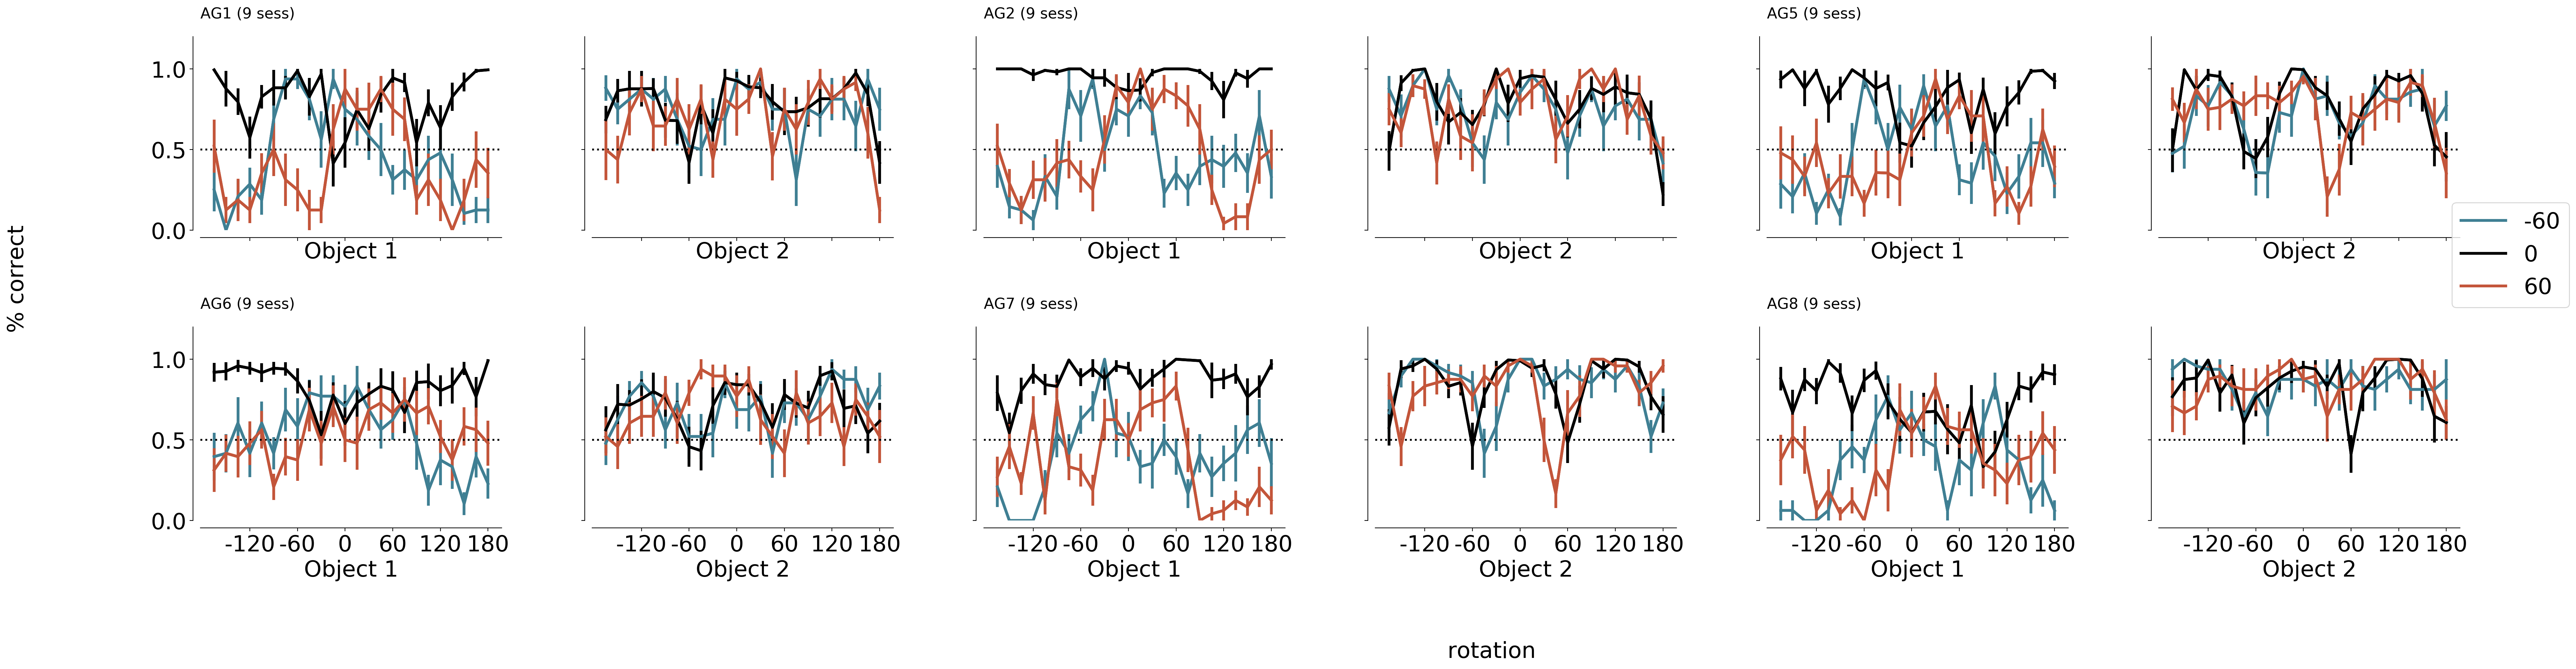

In [1041]:
nr=2
nc=3
fig, axes = pl.subplots(nr, nc*2, figsize=(nc*8*2, nr*6), sharex=True, sharey=True, dpi=dpi)
lw=3

ii = 0
for ai, (animalid, agroup) in enumerate(perfdf.groupby(['animalid'])):
    n_sessions = len(agroup['session'].unique())
    ii = ai*2
    for oi, (objectid, ogroup) in enumerate(agroup.groupby(['objectid'])):
        ax = axes.flat[ii+oi]        
        ogroup = agroup[agroup['objectid']==objectid]

        for hue_v, hgroup in ogroup.groupby([hue_feature]):
            if hue_v not in splits_to_plot:
                continue
                
            tested_values = [v for v, g in hgroup.groupby([curr_feature])]
            performance_values = [g['perc_correct'].mean() for v, g in hgroup.groupby([curr_feature])]
            peformance_sem = [spstats.sem(g['perc_correct']) for v, g in hgroup.groupby([curr_feature])]
        
            curr_color = 'k' if hue_v==0 else feature_colors[objectid][hue_v] 
            ax.plot(tested_values, performance_values, color=curr_color, 
                    label='%i' % (hue_v), linestyle='-', lw=lw)
            ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                        color=curr_color, linestyle='-', lw=lw)
        if oi==0:
            ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=16, pad=20, loc='left')
        ax.axhline(y=0.5, linestyle=':', color='k', lw=2)

        ax.set_ylim([0, 1.2])
        ax.set_xlabel('Object %s' % objectid)
        
        ax.set_yticks(np.linspace(0, 1, 3))
        xticks = [int(x) for x in x_axis_values if x%20==0 ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    
ax.legend(bbox_to_anchor=(1.4,1.7))

for i in np.arange(i, nr*nc):
    ax=axes.flat[i]
    ax.axis('off')

    
pl.subplots_adjust(left=0.1, right=0.8, top=0.8, hspace=0.5, wspace=0.3, bottom=0.2)

sns.despine(trim=False, offset=8) #, right=False)

fig.text(0.5, 0.03, curr_feature, ha='center')
fig.text(0.04, 0.5, '% correct', va='center', rotation='vertical')

figname = 'accuracy_by-%s_subsample_hue-%s_split-object_phase%i_%s' % (curr_feature, hue_feature, curr_phase, cohort)

pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
print(curr_outdir)
print(figname)



/n/coxfs01/behavior-data/threeport/processed/performance/inplane_rotations
avg_rt_by-rotation_hue-depth_rotation_split-object_phase6_AG


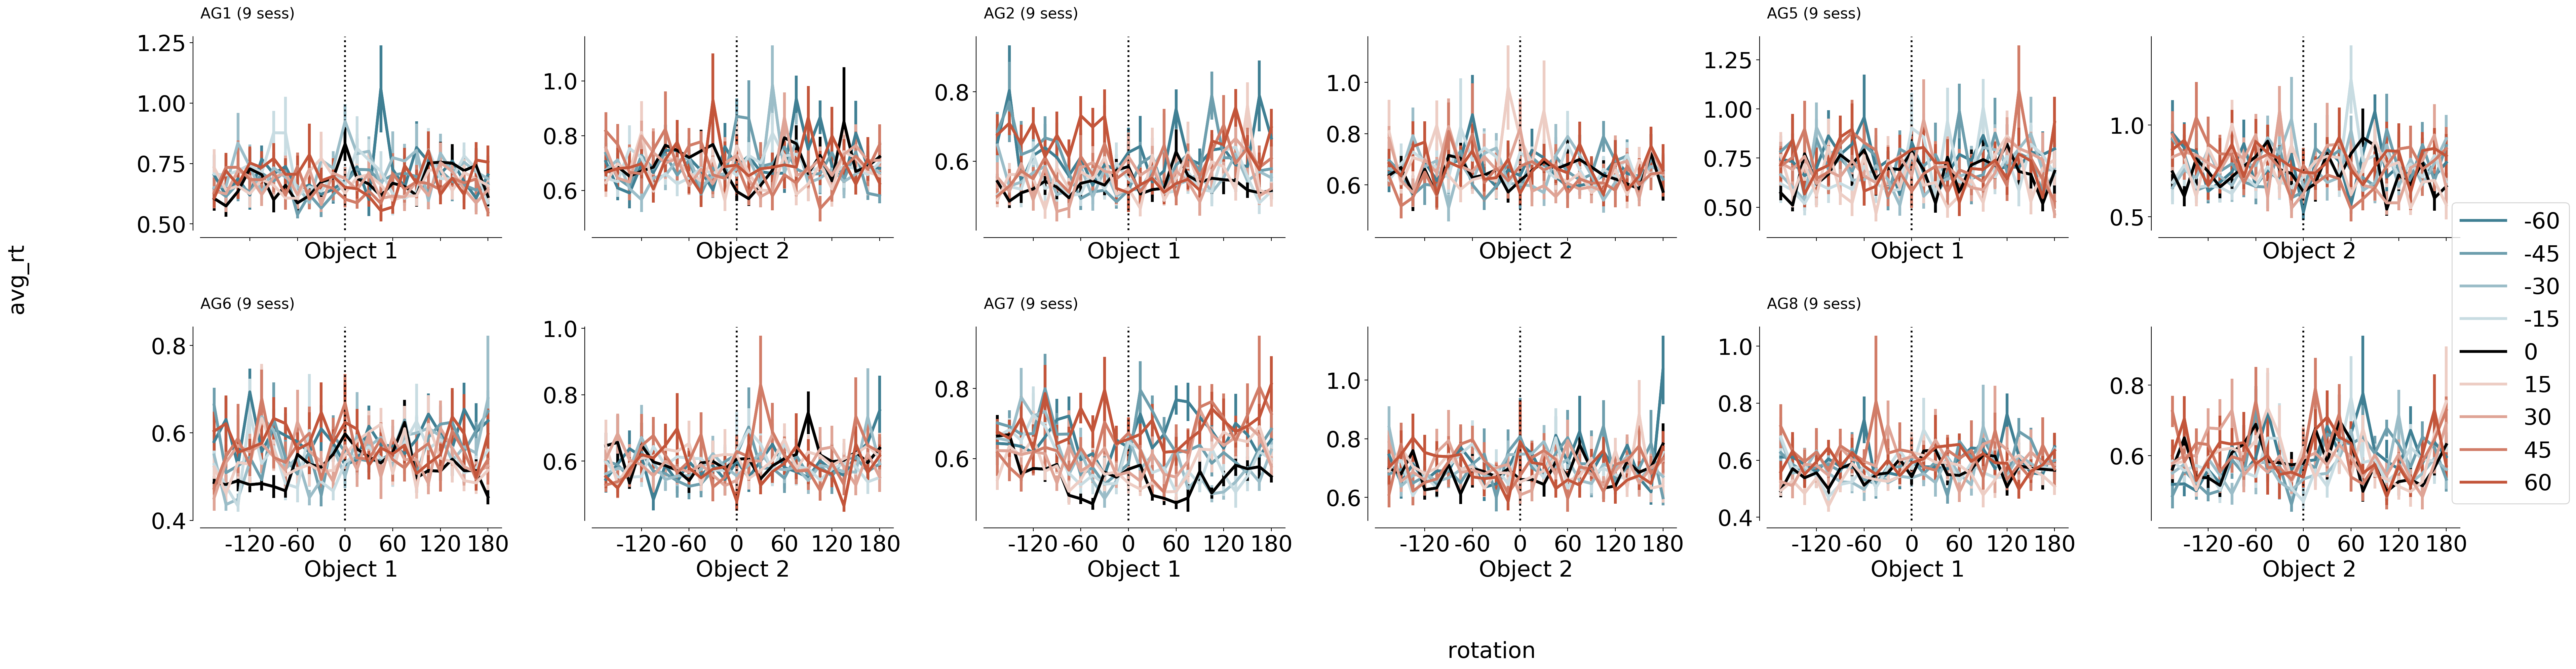

In [1047]:
nr=2
nc=3
fig, axes = pl.subplots(nr, nc*2, figsize=(nc*8*2, nr*6), sharex=True, sharey=False, dpi=dpi)
lw=3

curr_metric = 'avg_rt'
ii = 0
for ai, (animalid, agroup) in enumerate(perfdf.groupby(['animalid'])):
    n_sessions = len(agroup['session'].unique())
    ii = ai*2
    for oi, (objectid, ogroup) in enumerate(agroup.groupby(['objectid'])):
        ax = axes.flat[ii+oi]        
        ogroup = agroup[agroup['objectid']==objectid]

        for hue_v, hgroup in ogroup.groupby([hue_feature]):
#             if hue_v not in splits_to_plot:
#                 continue
                
            tested_values = [v for v, g in hgroup.groupby([curr_feature])]
            performance_values = [g[curr_metric].mean() for v, g in hgroup.groupby([curr_feature])]
            peformance_sem = [spstats.sem(g[curr_metric]) for v, g in hgroup.groupby([curr_feature])]
        
            curr_color = 'k' if hue_v==0 else feature_colors[objectid][hue_v] 
            ax.plot(tested_values, performance_values, color=curr_color, 
                    label='%i' % (hue_v), linestyle='-', lw=lw)
            ax.errorbar(tested_values, performance_values, yerr=peformance_sem, 
                        color=curr_color, linestyle='-', lw=lw)
        if oi==0:
            ax.set_title('%s (%i sess)' % (animalid, n_sessions), fontsize=16, pad=20, loc='left')
        #ax.axhline(y=0.5, linestyle=':', color='k', lw=2)
        ax.axvline(x=training_value, linestyle=':', color='k', lw=2)
        
        #ax.set_ylim([0, 1.2])
        ax.set_xlabel('Object %s' % objectid)
        
        #ax.set_yticks(np.linspace(0, 1, 3))
        xticks = [int(x) for x in x_axis_values if x%20==0 ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    
ax.legend(bbox_to_anchor=(1.4,1.7))

for i in np.arange(i, nr*nc):
    ax=axes.flat[i]
    ax.axis('off')

    
pl.subplots_adjust(left=0.1, right=0.8, top=0.8, hspace=0.5, wspace=0.3, bottom=0.2)

sns.despine(trim=False, offset=8) #, right=False)

fig.text(0.5, 0.03, curr_feature, ha='center')
fig.text(0.04, 0.5, curr_metric, va='center', rotation='vertical')

figname = '%s_by-%s_hue-%s_split-object_phase%i_%s' % (curr_metric, curr_feature, hue_feature, curr_phase, cohort)

pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
print(curr_outdir)
print(figname)


In [139]:
test = perfdf[perfdf['animalid']=='AG7'].sort_values(by=['size', 'depth_rotation'])['size'].values


In [141]:
perfdf[perfdf['animalid']=='AG7'].groupby(['size', 'depth_rotation']).mean()

n_trials  perc_correct       session
size depth_rotation                                       
15.0  0              23.000000      0.515236  2.016096e+07
20.0  0              22.888889      0.589425  2.016096e+07
25.0  0              22.833333      0.657536  2.016096e+07
30.0  0              22.666667      0.673753  2.016096e+07
35.0 -60             22.833333      0.544722  2.016096e+07
     -45             22.722222      0.521032  2.016096e+07
     -30             23.000000      0.643056  2.016096e+07
     -15             22.722222      0.678376  2.016096e+07
      0              22.888889      0.690913  2.016096e+07
      15             22.777778      0.717852  2.016096e+07
      30             22.888889      0.655659  2.016096e+07
      45             22.666667      0.661555  2.016096e+07
      60             22.888889      0.547195  2.016096e+07
40.0  0              22.833333      0.695929  2.016096e+07

In [163]:
sorted(perfdf[perfdf['animalid']=='AG7']['session'].unique())

[20160913, 20160915, 20160920, 20160921, 20160922, 20161012, 20161013]